In [1]:
import matplotlib.pyplot as plt
import holopy as hp
from holopy.scattering import Scatterer, Sphere, calc_holo, calc_field, Spheres, Ellipsoid
from holopy.scattering.theory import Lens, DDA
from holopy.core.utils import ensure_array
import numpy as np
import scipy as sp
import pandas as pd
from scipy import interpolate
import skimage.transform
import gc, os
from tqdm import tqdm

In [2]:
import newsdm_utils

In [2]:
from holopy.scattering.theory.backscatter import Backscattered
from holopy.sandbox.newsdm_utils import *

In [3]:
import subprocess
import tempfile
import glob
import os
import shutil
import time
import warnings

import numpy as np

from holopy.core.utils import ensure_array, SuppressOutput
from holopy.scattering.scatterer import (
    Ellipsoid, Capsule, Cylinder, Bisphere, Sphere, Scatterer, Spheroid)
from holopy.core.errors import DependencyMissing
from holopy.scattering.theory.scatteringtheory import ScatteringTheory


class DDA(ScatteringTheory):
    """
    Computes scattering using the the Discrete Dipole Approximation (DDA).
    It can (in principle) calculate scattering from any arbitrary scatterer.
    The DDA uses a numerical method that represents arbitrary scatterers as
    an array
    of point dipoles and then self-consistently solves Maxwell's equations
    to determine the scattered field. In practice, this model can be
    extremely computationally intensive, particularly if the size of the
    scatterer is larger than the wavelength of light.  This model requires an
    external scattering code: `a-dda <http://code.google.com/p/a-dda/>`_
    Attributes
    ----------
    n_cpu : int (optional)
        Number of threads to use for the DDA calculation
    max_dpl_size : float (optional)
        Force a maximum dipole size. This is useful for forcing extra
        dipoles if necessary to resolve features in an object. This may
        make dda calculations take much longer.
    use_indicators : bool
        If true, a scatterer's indicators method will be used instead of
        its built-in adda definition
    keep_raw_calculations : bool
        If true, do not delete the temporary file we run ADDA in,
        instead print its path so you can inspect its raw results
    Notes
    -----
    Does not handle near fields. This introduces ~5% error at 10
    microns. This can in principle handle any scatterer, but in practice
    it will need excessive memory or computation time for particularly
    large scatterers.
    """
    def __init__(self, n_cpu=1, use_gpu=False, gpu_id=None, max_dpl_size=None,
                 use_indicators=True, keep_raw_calculations=False, addacmd=[],
                 suppress_C_output=True, transpose_matr=True):

        # Check that adda is present and able to run
        try:
            with SuppressOutput(suppress_output=suppress_C_output):
                subprocess.check_call(['adda', '-V'])
        except (subprocess.CalledProcessError, OSError):
            raise DependencyMissing('adda', "adda is not included with HoloPy "
                "and must be installed separately. You should be able to run "
                "the command 'adda' from a terminal.")

        self.n_cpu = n_cpu
        self.use_gpu = use_gpu
        self.gpu_id = gpu_id
        self.max_dpl_size = max_dpl_size
        self.use_indicators = use_indicators
        self.keep_raw_calculations = keep_raw_calculations
        self.addacmd = addacmd
        self.suppress_C_output = suppress_C_output
        self.transpose_matr = transpose_matr
        if use_gpu and n_cpu>1: warnings.warn("Adda cannot run on multiple CPUs, when running on GPU. 1 CPU will be used.")
        super().__init__()

    @classmethod
    def can_handle(cls, scatterer):
        # For now DDA is our most general theory, eventually this will have to
        # change if we add other theorys that can compute things ADDA can't (or
        # shouldn't, because it would take crazy long)
        return isinstance(scatterer, Scatterer)

    def _run_adda(self, scatterer, medium_wavevec, medium_index, temp_dir):
        medium_wavelen = 2*np.pi/medium_wavevec
        if self.use_gpu:
            cmd = ['adda_ocl']
            if self.gpu_id is not None: cmd.extend(['-gpu',str(self.gpu_id)])
        elif self.n_cpu == 1:
            cmd = ['adda']
        elif self.n_cpu > 1:
            cmd = ['mpiexec', '-n', str(self.n_cpu), 'adda_mpi']
        cmd.extend(['-scat_matr', 'ampl'])
        cmd.extend(['-store_scat_grid'])
        cmd.extend(['-lambda', str(medium_wavelen)])
        cmd.extend(['-save_geom'])
        cmd.extend(self.addacmd)

        predefined = isinstance(scatterer, tuple(_get_predefined_shape.keys()))
        layered=isinstance(scatterer, Sphere) and not np.isscalar(scatterer.r)
        if not predefined or self.use_indicators or layered:
            scat_args = self._adda_discretized(scatterer, medium_wavelen, medium_index, temp_dir)
        else:
            scat_args = self._adda_predefined(scatterer, medium_wavelen, medium_index, temp_dir)
        cmd.extend(scat_args)
        with SuppressOutput(suppress_output=self.suppress_C_output):
            subprocess.check_call(cmd, cwd=temp_dir)

    # TODO: figure out why our discretization gives a different result
    # and fix so that we can use that and eliminate this.
    def _adda_predefined(self, scatterer, medium_wavelen, medium_index, temp_dir):
        scatterer_pars = _get_predefined_shape[scatterer.__class__](scatterer)
        cmd = []
        cmd.extend(['-eq_rad', str(scatterer_pars[0]), '-shape'])
        cmd.extend(scatterer_pars[1])
        cmd.extend(['-m', str(scatterer.n.real/medium_index),
                    str(scatterer.n.imag/medium_index)])
        if hasattr(scatterer, 'rotation'):
            cmd.extend(['-orient'])
            cmd.extend([str(angle*180/np.pi) for angle in reversed(scatterer.rotation)])
            # rotation angles are gamma, beta, alpha in adda reference frame
        return cmd

    def _adda_discretized(self, scatterer, medium_wavelen, medium_index, temp_dir):
        spacing = self.required_spacing(scatterer.bounds, medium_wavelen, medium_index, scatterer.n)
        outf = tempfile.NamedTemporaryFile(dir = temp_dir, delete=False)

        vox = scatterer.voxelate_domains(spacing)
        idx = np.concatenate([g[..., np.newaxis] for g in
                              np.mgrid[[slice(0,d) for d in vox.shape]]],
                             3).reshape((-1, 3))
        vox = vox.flatten()
        ns = ensure_array(scatterer.n)
        n_domains = len(ns)
        if n_domains > 1:
            out = np.hstack((idx, vox[...,np.newaxis]))
            outf.write("Nmat={0}\n".format(n_domains).encode('utf-8'))
        else:
            out = idx
        np.savetxt(outf, out[np.nonzero(vox)], fmt='%d')
        outf.close()

        cmd = []
        cmd.extend(['-shape', 'read', outf.name])
        cmd.extend(
            ['-dpl', str(self._dpl(scatterer.bounds, medium_wavelen, medium_index, scatterer.n))])
        cmd.extend(['-m'])
        for n in ns:
            m = n.real/medium_index
            if m == 1:
                warnings.warn("Adda cannot compute particles with index equal to medium index, adjusting particle index {} to {}".format(m, m+1e-6))
                m += 1e-6
            cmd.extend([str(m), str(n.imag/medium_index)])
        return cmd

    def _dpl(self, bounds, medium_wavelen, medium_index, n):
        # for objects much smaller than wavelength we should use
        # at least 10 dipoles per smallest dimension
        dpl = 10*medium_wavelen / min([np.abs(b[1]-b[0]) for b in bounds])
        # if the object has multiple domains, we need to pick the
        # largest required dipole number
        n = np.abs(n)
        if not np.isscalar(n):
            n = max(n)
        dpl = max(dpl, 10*(n/medium_index))
        # This allows you to fix a largest allowable dipole size (ie
        # so you can resolve features in an object)
        if self.max_dpl_size is not None:
            dpl = max(dpl, medium_wavelen / self.max_dpl_size)
        return dpl

    def required_spacing(self, bounds, medium_wavelen, medium_index, n):
        return medium_wavelen / self._dpl(bounds, medium_wavelen, medium_index, n)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        angles = pos.T[:, 1:] * 180/np.pi
        temp_dir = tempfile.mkdtemp()

        outf = open(os.path.join(temp_dir, 'scat_params.dat'), 'wb')

        # write the header on the scattering angles file
        header = ["global_type=pairs", "N={0}".format(len(angles)), "pairs="]
        outf.write(('\n'.join(header)+'\n').encode('utf-8'))
        # Now write all the angles
        np.savetxt(outf, angles)
        outf.close()

        self._run_adda(
            scatterer, medium_wavevec=medium_wavevec,
            medium_index=medium_index, temp_dir=temp_dir)

        # Go into the results directory, there should only be one run
        result_dir = glob.glob(os.path.join(temp_dir, 'run000*'))[0]
        if self.keep_raw_calculations:
            self._last_result_dir = result_dir

        adda_result = np.loadtxt(os.path.join(result_dir, 'ampl_scatgrid'),
                                 skiprows=1)
        # columns in result are
        # theta phi s1.r s1.i s2.r s2.i s3.r s3.i s4.r s4.i

        # Combine the real and imaginary components from the file into complex
        # numbers
        s = adda_result[:,2::2] + 1.0j*adda_result[:,3::2]

        # Now arrange them into a scattering matrix, see Bohren and Huffman p63
        # eq 3.12
        if self.transpose_matr:
            scat_matr = np.array([[s[:,1], s[:,2]], [s[:,3], s[:,0]]]).transpose()
        else:
            ### REVERSE TRAMSPOSE TEST
            scat_matr = np.array([[s[:,1], s[:,3]], [s[:,2], s[:,0]]]).transpose()

        if self.keep_raw_calculations:
            print(("Raw calculations are in: {0}".format(temp_dir)))
        else:
            shutil.rmtree(temp_dir)

        return scat_matr
    
_get_predefined_shape = {
        Ellipsoid: lambda s:(s.r[0], ['ellipsoid'] +
                                        [str(r_i/s.r[0]) for r_i in s.r[1:]]),
        Spheroid: lambda s: (s.r[0], ['ellipsoid', '1', str(s.r[1]/s.r[0])]),
        Capsule: lambda s: ((s.h+s.d)/2, ['capsule', str(s.h/s.d)]),
        Cylinder: lambda s: (s.h/2, ['cylinder', str(s.h/s.d)]),
        Bisphere: lambda s: ((s.h+s.d)/2, ['bisphere', str(s.h/s.d)]),
        Sphere: lambda s: (s.r, ['sphere'])}

In [4]:
import numpy as np
from holopy.scattering.theory.scatteringtheory import ScatteringTheory

class Backscattered(ScatteringTheory):
    def __init__(self, theory, transpose_back=False):
        self.theory = theory
        self.transpose_back = transpose_back

    def can_handle(self, scatterer):
        return self.theory.can_handle(scatterer)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        r, theta, phi = pos
        theta_backscattered = np.pi - theta
        pos_backscattered = np.array([r, theta_backscattered, phi])

        args = (scatterer, pos_backscattered, medium_wavevec, medium_index)
        scat_matrices = np.array(self.theory.raw_scat_matrs(*args))

        # account for coordinate change in decomposition of incoming
        # light into theta, phi components:
        scat_matrices[:, 0, 0] *= -1
        if not self.transpose_back:
            scat_matrices[:, 0, 1] *= -1  # FIXME is it this or the transpose? NO
        else:
            scat_matrices[:, 1, 0] *= -1

        return scat_matrices

# Biellipsoid

In [84]:
Ag_n = np.loadtxt('Ag_wu14.txt')
lamb_min = Ag_n[0,0]; lamb_max = Ag_n[-1,0]
m_ag = {}
m_ag['R'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,1], kind='cubic')
m_ag['I'] = sp.interpolate.interp1d(Ag_n[:,0], Ag_n[:,2], kind='cubic')

## article imgs

In [75]:
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.05), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

filam = np.array(biel.voxelate(spacing=0.002), dtype=bool)

#filled = np.zeros((filam[:,0].max()+1, filam[:,1].max()+1, filam[:,2].max()+1), dtype=bool)
#for c in filam:
#    filled[c[0],c[1],c[2]] = True

print(filam.shape)
# copa_fil = np.concatenate((np.zeros((100,24,50), dtype=bool), filam, np.zeros((100,25,50), dtype=bool)), axis=1)
# copa_fil_fil = np.concatenate((np.zeros((100,100,25), dtype=bool), copa_fil, np.zeros((100,100,25), dtype=bool)), axis=2)
# ax = make_ax(True)
# ax.voxels(copa_fil_fil, edgecolors='gray', shade=False)
# plt.savefig('thesis/ellip_voxel.png')
# plt.show()

(101, 200, 50)


In [82]:
copa_fil = np.concatenate((np.zeros((50,200,50), dtype=bool), filam, np.zeros((49,200,50), dtype=bool)), axis=0)
copa_fil_fil = np.concatenate((np.zeros((200,200,75), dtype=bool), copa_fil, np.zeros((200,200,75), dtype=bool)), axis=2)
np.sum(copa_fil_fil, axis=(1,2))

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1,   69,  149,  225,  293,
        373,  437,  509,  577,  641,  709,  769,  829,  885,  949,  997,
       1049, 1101, 1161, 1201, 1257, 1305, 1353, 1389, 1433, 1482, 1808,
       2146, 2458, 2774, 3044, 3346, 3597, 3846, 4072, 4281, 4485, 4688,
       4867, 5042, 5176, 5317, 5414, 5523, 5646, 5706, 5760, 5800, 5832,
       5836, 5860, 5836, 5832, 5800, 5760, 5706, 5646, 5523, 5414, 5317,
       5176, 5042, 4867, 4688, 4485, 4281, 4072, 3846, 3597, 3346, 3044,
       2774, 2458, 2146, 1797, 1481, 1433, 1389, 1353, 1305, 1250, 1201,
       1157, 1101, 1049,  997,  949,  885,  829,  769,  698,  641,  577,
        509,  437,  373,  293,  225,  145,   69,   

/home/scanner-ml/anaconda3/envs/ML_rebuild/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().


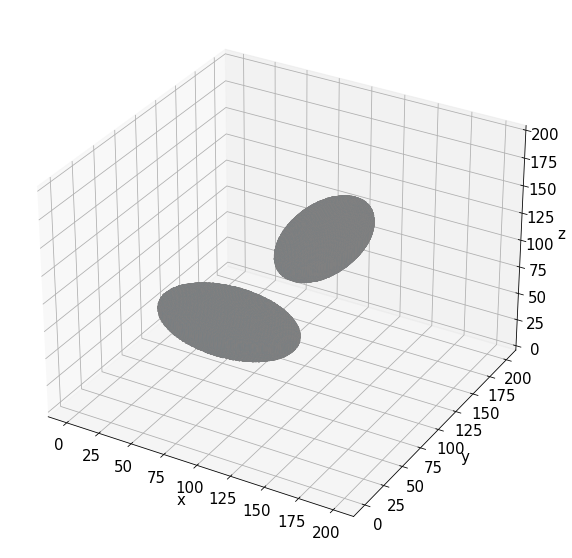

CPU times: user 4min 52s, sys: 7.2 s, total: 4min 59s
Wall time: 4min 47s


In [83]:
%%time
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.05), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

filam = np.array(biel.voxelate(spacing=0.002), dtype=bool)

copa_fil = np.concatenate((np.zeros((50,200,50), dtype=bool), filam, np.zeros((49,200,50), dtype=bool)), axis=0)
copa_fil_fil = np.concatenate((np.zeros((200,200,75), dtype=bool), copa_fil, np.zeros((200,200,75), dtype=bool)), axis=2)
ax = make_ax(True)
ax.voxels(copa_fil_fil, edgecolors='gray', shade=False)
plt.savefig('thesis/biellip_voxel.png')
plt.show()

In [85]:
%%time
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.05), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = m_ag['R'](0.460)+1j*m_ag['I'](0.460), center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=False, suppress_C_output=False, max_dpl_size=0.002), transpose_back=False))#, addacmd=['-orient',str(th),'0','0']))
holo_unp_back = newsdm_utils.calc_unpolar(detector, scat=biel, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.02638'
Geometry saved to file
box dimensions: 100x199x49
lambda: 0.3458646617   Dipoles/lambda: 172.932
Required relative residual norm: 1e-05
Total number of occupied dipoles: 261035

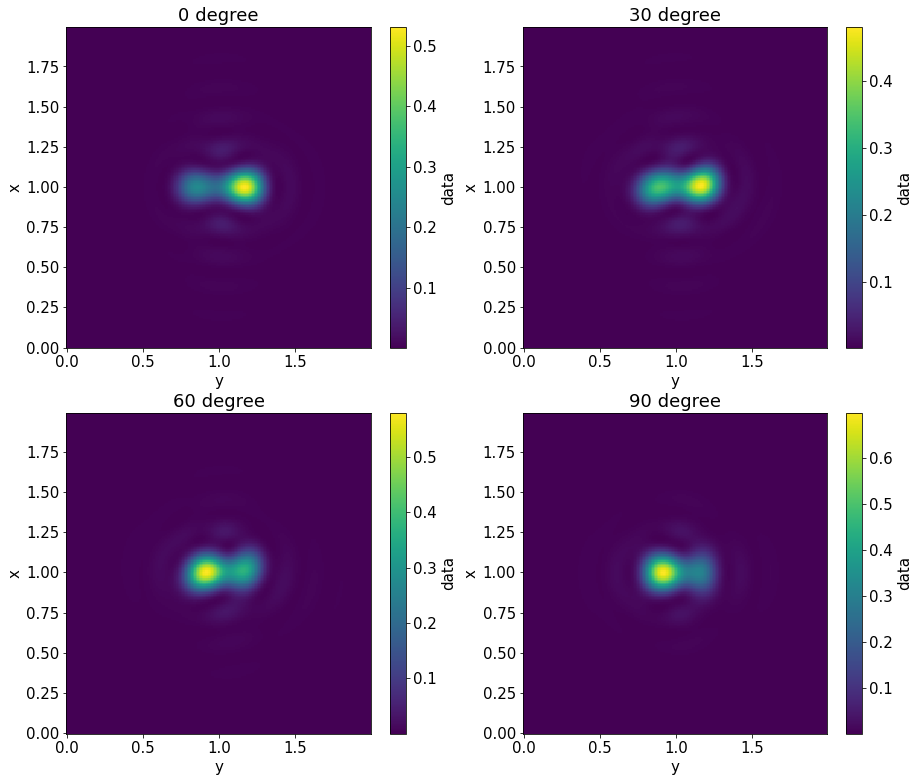

In [110]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp_back, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
# fig.suptitle('Bi-ellipsoid, back-scattered light')
plt.savefig('thesis/biellip_back.png')
plt.show()

### barshift

In [98]:
w = 4
br_peak = []
for th in np.linspace(0,180,18, endpoint=False):
    br_peak.append(newsdm_utils.bright_cen(newsdm_utils.apply_pol(holo_unp_back, th*np.pi/180).values, w=w))
br_peak = np.array(br_peak).T

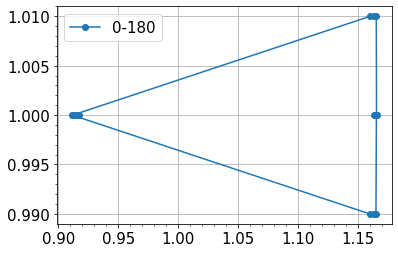

In [112]:
plt.plot(br_peak[1,:]*0.01, br_peak[0,:]*0.01, '-o', label='0-180')
# plt.xlim(0.46,0.56)
# plt.ylim(0.495,0.625)
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.title(str(w))
plt.savefig('thesis/biellip_barshift.png')
plt.show()

In [108]:
br_peak.T

array([[100.        , 116.34972017],
       [100.        , 116.53331761],
       [101.        , 116.5115734 ],
       [101.        , 116.31796618],
       [101.        , 116.01698936],
       [100.        ,  91.21059508],
       [100.        ,  91.59510575],
       [100.        ,  91.59402332],
       [100.        ,  91.68464472],
       [100.        ,  91.70988165],
       [100.        ,  91.67363562],
       [100.        ,  91.57196635],
       [100.        ,  91.55945056],
       [100.        ,  91.16374438],
       [ 99.        , 115.97298196],
       [ 99.        , 116.28240643],
       [ 99.        , 116.48594975],
       [100.        , 116.52223966]])

In [109]:
import itertools

bar_max = 0
for a,b in itertools.combinations(br_peak.T, 2):
    dist = np.sqrt(np.sum([(i-j)**2 for i,j in zip(a,b)]))*0.01
    if dist>bar_max:
        bar_max = dist
print(bar_max)

0.25369573232075726


In [87]:
%%time
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.05), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = m_ag['R'](0.460)+1j*m_ag['I'](0.460), center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, DDA(use_gpu=True, transpose_matr=False, suppress_C_output=False, max_dpl_size=0.002))#, addacmd=['-orient',str(th),'0','0']))
holo_unp_forw = newsdm_utils.calc_unpolar(detector, scat=biel, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.02638'
Geometry saved to file
box dimensions: 100x199x49
lambda: 0.3458646617   Dipoles/lambda: 172.932
Required relative residual norm: 1e-05
Total number of occupied dipoles: 261035

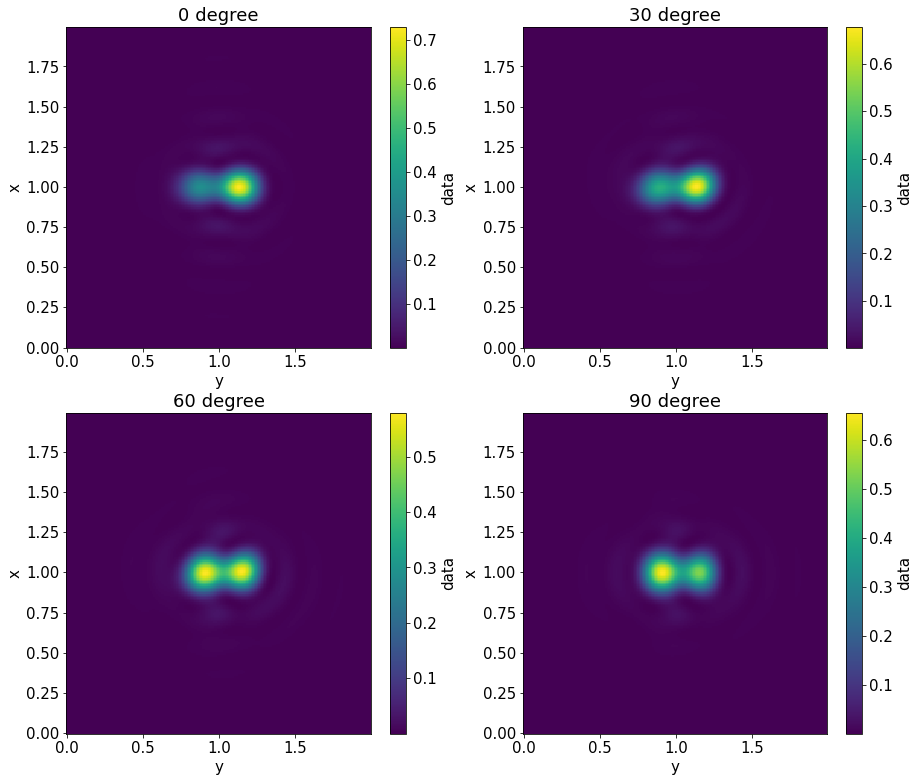

In [111]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp_forw, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
# fig.suptitle('Bi-ellipsoid, forward scatter')
plt.savefig('thesis/biellip_forw.png')
plt.show()

In [96]:
w = 4
br_peak = []
for th in np.linspace(0,180,18, endpoint=False):
    br_peak.append(newsdm_utils.bright_cen(newsdm_utils.apply_pol(holo_unp_forw, th*np.pi/180).values, w=w))
br_peak = np.array(br_peak).T

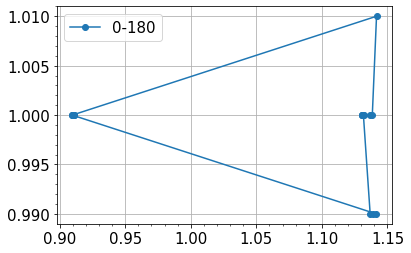

In [97]:
plt.plot(br_peak[1,:]*0.01, br_peak[0,:]*0.01, '-o', label='0-180')
# plt.xlim(0.46,0.56)
# plt.ylim(0.495,0.625)
plt.legend()
plt.grid()
plt.minorticks_on()
#plt.title(str(w))
# plt.savefig('cdr/adda_2fil_barshift.png')
plt.show()

## Bielipsoid tests

### Adda-T, back-noT

In [53]:
%%time
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=True, suppress_C_output=False, max_dpl_size=0.002), transpose_back=False))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=biel, medium_index=1.33, illum_wavelen=0.4, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.03759'
Geometry saved to file
box dimensions: 100x199x499
lambda: 0.3007518797   Dipoles/lambda: 150.376
Required relative residual norm: 1e-05
Total number of occupied dipoles: 14383

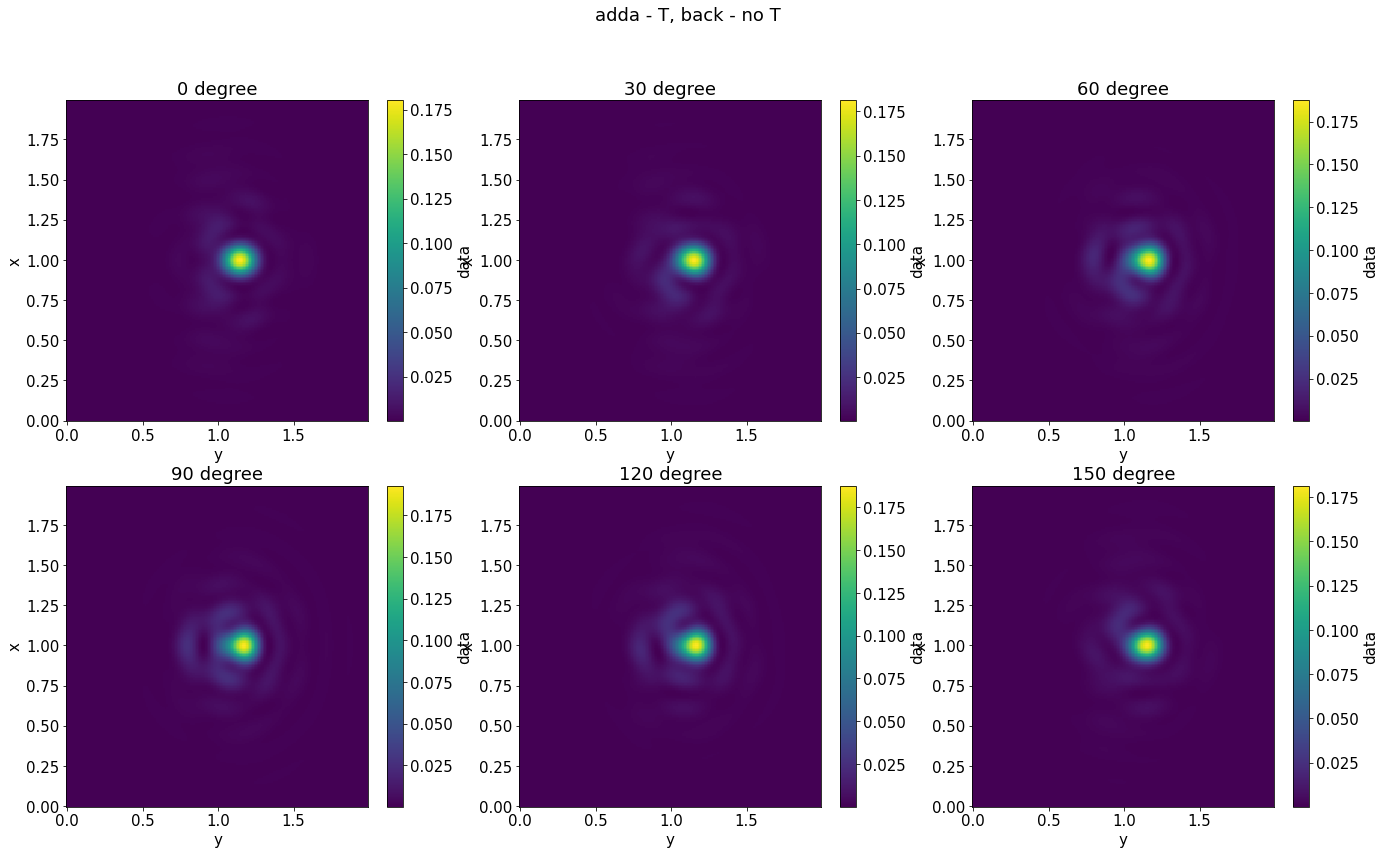

In [54]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - T, back - no T')
plt.show()

In [55]:
ell = Ellipsoid(r = (0.1,0.05,0.05), n = 0.035+1j*2.809, center = (0.5,0.5,0))
detector = hp.detector_grid(100, .01)

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=True, suppress_C_output=False, max_dpl_size=0.002), transpose_back=False))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.02632'
Geometry saved to file
box dimensions: 100x50x49
lambda: 0.3458646617   Dipoles/lambda: 172.932
Required relative residual norm: 1e-05
Total number of occupied dipoles: 130512


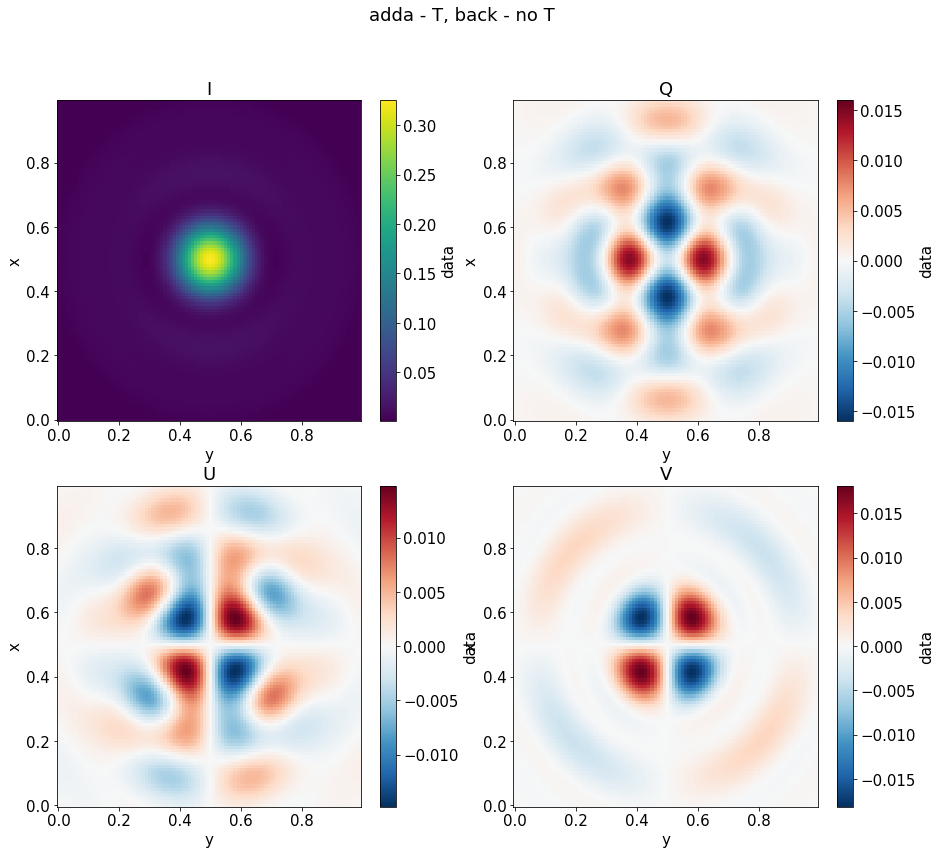

In [56]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
# plt.savefig('cdr/adda_biellip_unpol.png')
fig.suptitle('adda - T, back - no T')
plt.show()

### Adda-noT, back-noT

In [57]:
%%time
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=False, suppress_C_output=False, max_dpl_size=0.002), transpose_back=False))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=biel, medium_index=1.33, illum_wavelen=0.4, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.03759'
Geometry saved to file
box dimensions: 100x199x499
lambda: 0.3007518797   Dipoles/lambda: 150.376
Required relative residual norm: 1e-05
Total number of occupied dipoles: 14383

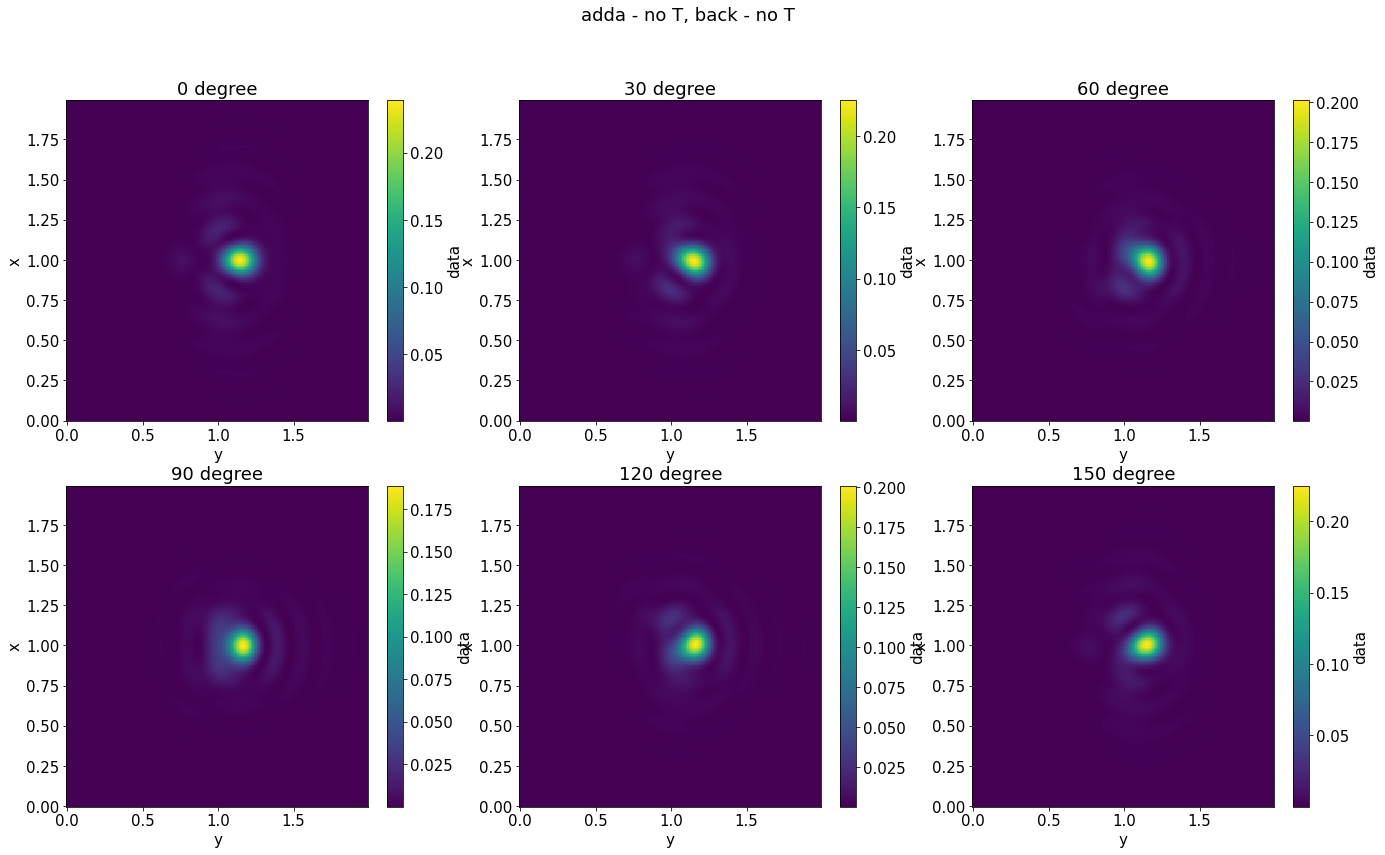

In [58]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - no T, back - no T')
plt.show()

In [59]:
ell = Ellipsoid(r = (0.1,0.05,0.05), n = 0.035+1j*2.809, center = (0.5,0.5,0))
detector = hp.detector_grid(100, .01)

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=False, suppress_C_output=False, max_dpl_size=0.002), transpose_back=False))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.02632'
Geometry saved to file
box dimensions: 100x50x49
lambda: 0.3458646617   Dipoles/lambda: 172.932
Required relative residual norm: 1e-05
Total number of occupied dipoles: 130512


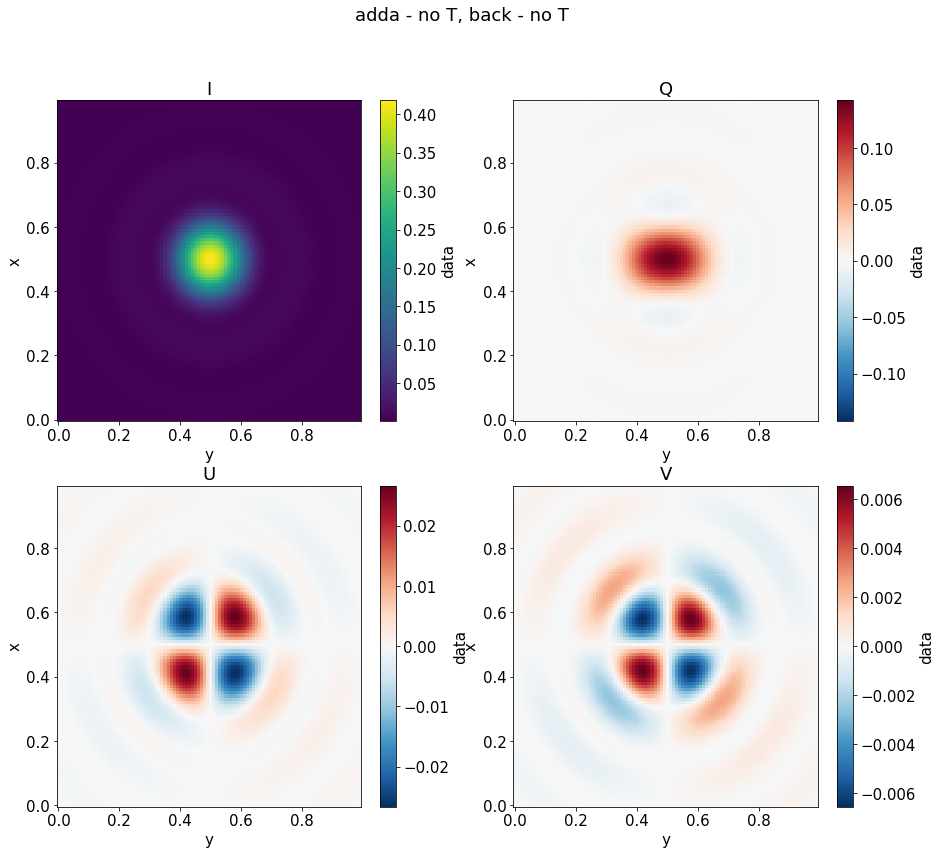

In [60]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
# plt.savefig('cdr/adda_biellip_unpol.png')
fig.suptitle('adda - no T, back - no T')
plt.show()

### Adda-T, back-T

In [61]:
%%time
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=True, suppress_C_output=False, max_dpl_size=0.002), transpose_back=True))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=biel, medium_index=1.33, illum_wavelen=0.4, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.03759'
Geometry saved to file
box dimensions: 100x199x499
lambda: 0.3007518797   Dipoles/lambda: 150.376
Required relative residual norm: 1e-05
Total number of occupied dipoles: 14383

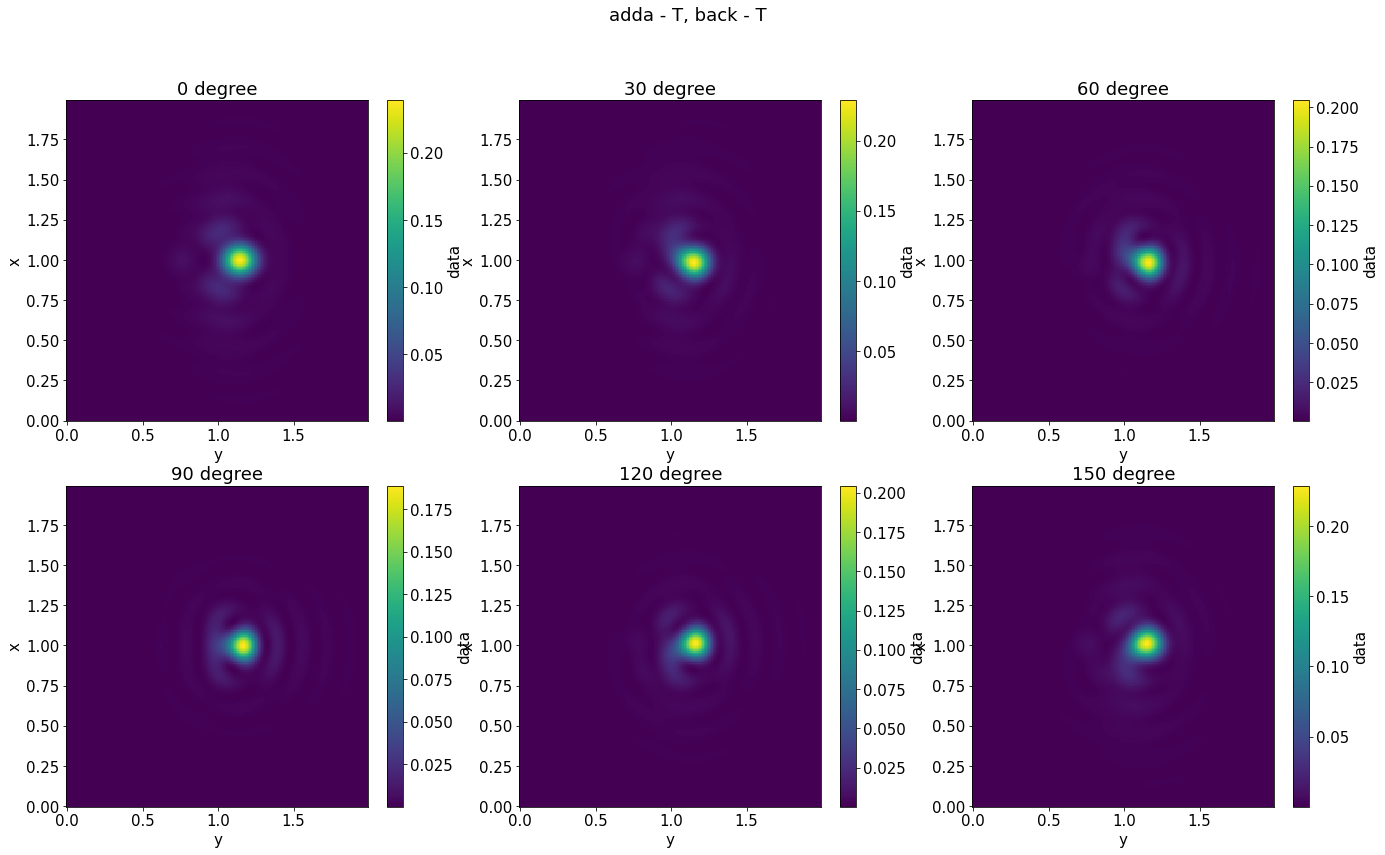

In [62]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - T, back - T')
plt.show()

In [63]:
ell = Ellipsoid(r = (0.1,0.05,0.05), n = 0.035+1j*2.809, center = (0.5,0.5,0))
detector = hp.detector_grid(100, .01)

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=True, suppress_C_output=False, max_dpl_size=0.002), transpose_back=True))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.02632'
Geometry saved to file
box dimensions: 100x50x49
lambda: 0.3458646617   Dipoles/lambda: 172.932
Required relative residual norm: 1e-05
Total number of occupied dipoles: 130512


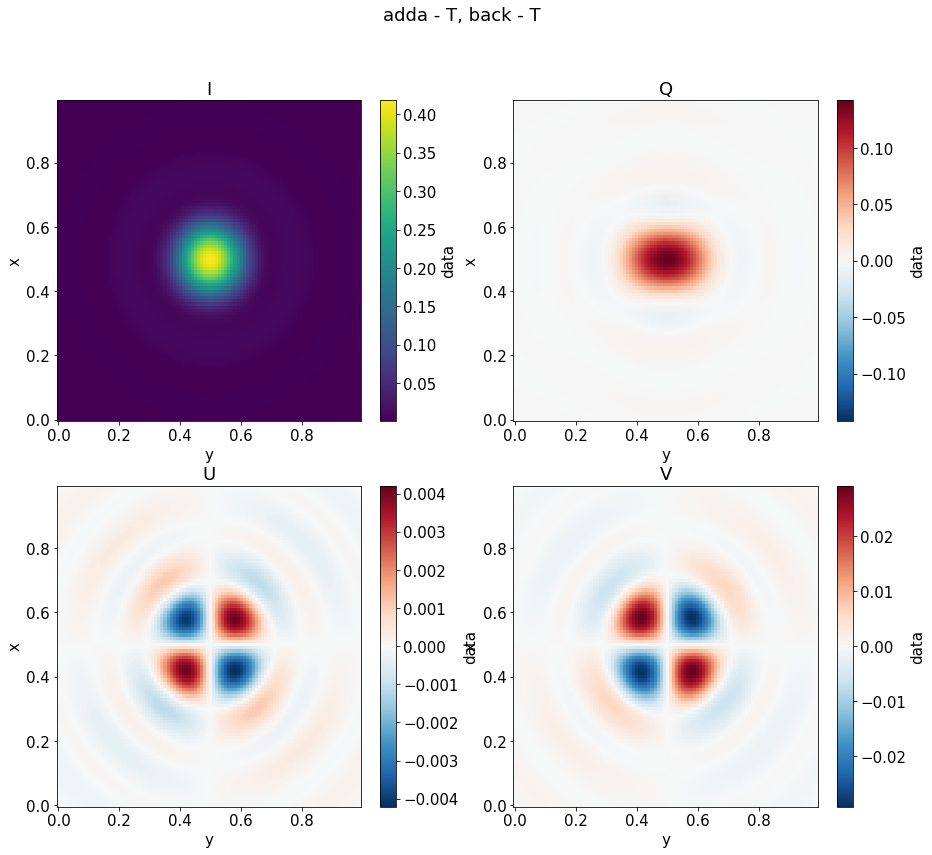

In [64]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
# plt.savefig('cdr/adda_biellip_unpol.png')
fig.suptitle('adda - T, back - T')
plt.show()

### Adda-noT, back-T

In [65]:
%%time
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=False, suppress_C_output=False, max_dpl_size=0.002), transpose_back=True))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=biel, medium_index=1.33, illum_wavelen=0.4, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.03759'
Geometry saved to file
box dimensions: 100x199x499
lambda: 0.3007518797   Dipoles/lambda: 150.376
Required relative residual norm: 1e-05
Total number of occupied dipoles: 14383

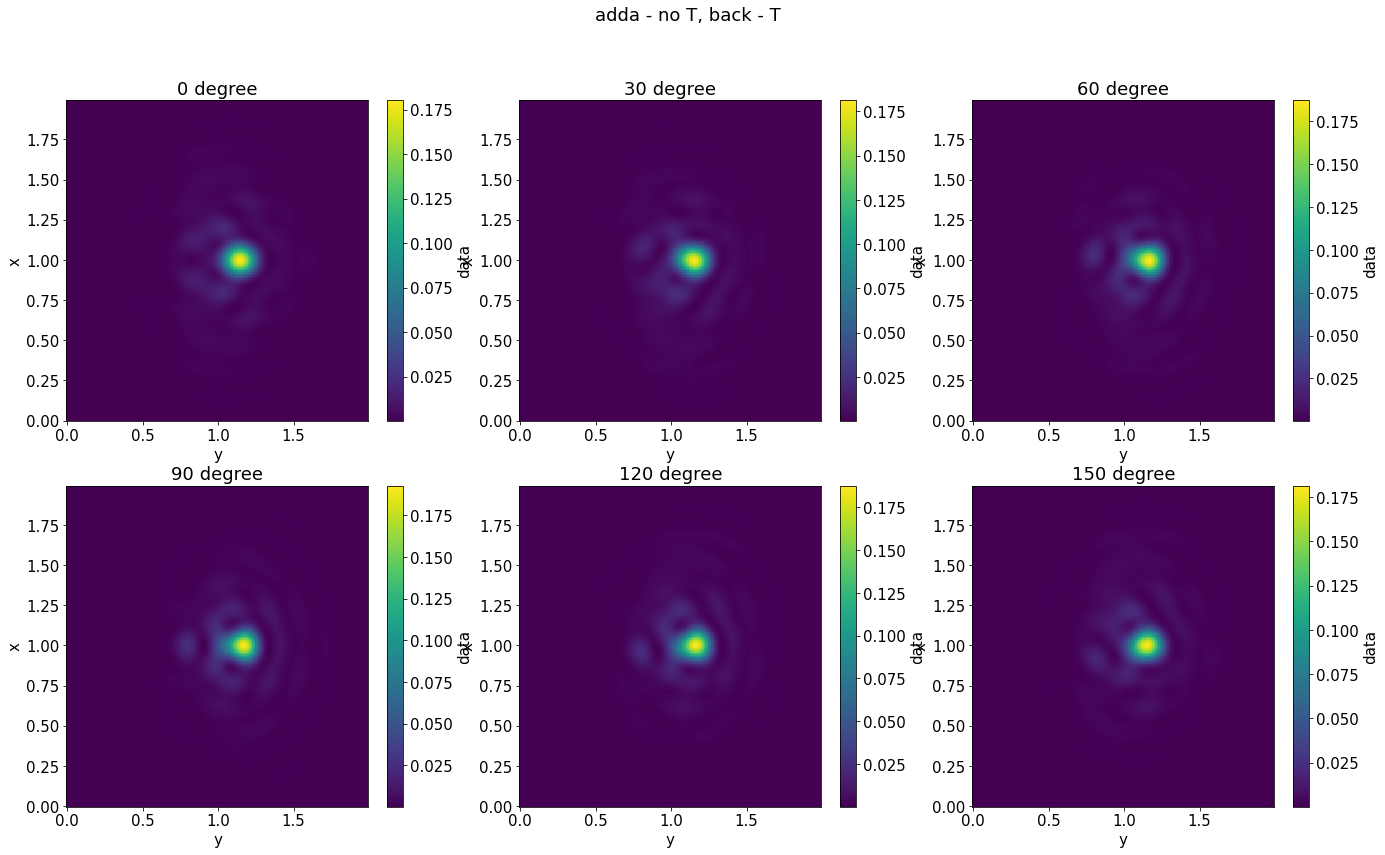

In [66]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - no T, back - T')
plt.show()

In [67]:
ell = Ellipsoid(r = (0.1,0.05,0.05), n = 0.035+1j*2.809, center = (0.5,0.5,0))
detector = hp.detector_grid(100, .01)

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, transpose_matr=False, suppress_C_output=False, max_dpl_size=0.002), transpose_back=True))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.02632'
Geometry saved to file
box dimensions: 100x50x49
lambda: 0.3458646617   Dipoles/lambda: 172.932
Required relative residual norm: 1e-05
Total number of occupied dipoles: 130512


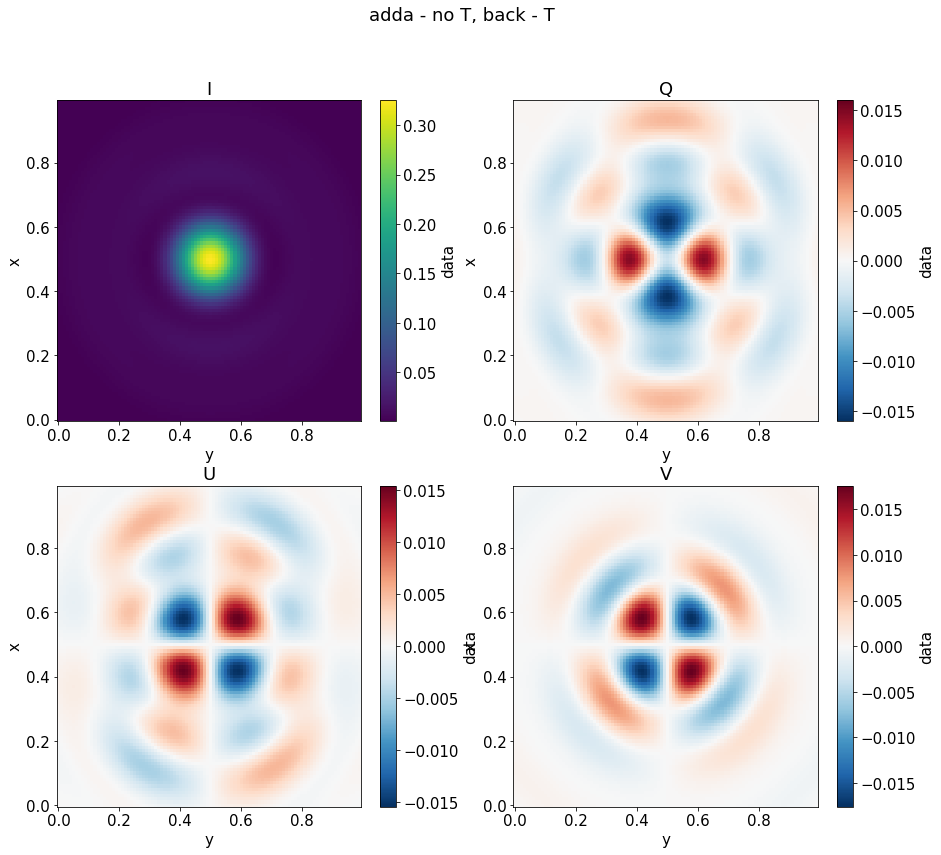

In [68]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
# plt.savefig('cdr/adda_biellip_unpol.png')
fig.suptitle('adda - no T, back - T')
plt.show()

# Transpose test (no backscatter)

### Adda-noT

In [15]:
%%time
# ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
# ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
# biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))
ell = Ellipsoid(r = (0.1,0.05,0.05), n = 0.05+1j*2.1, center = (1,1,0))
detector = hp.detector_grid(200, .01)

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
# bond = np.array(biel.bounds)
# c = biel.center
# for i,b in enumerate(bond):
#     bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
#     bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
# biel.indicators.bound = bond

len_dda = Lens(1.38, DDA(use_gpu=True, transpose_matr=False, suppress_C_output=False))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.4, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g20_m0.03759'
Geometry saved to file
box dimensions: 20x9x9
lambda: 0.3007518797   Dipoles/lambda: 30.0752
Required relative residual norm: 1e-05
Total number of occupied dipoles: 988
Searchi

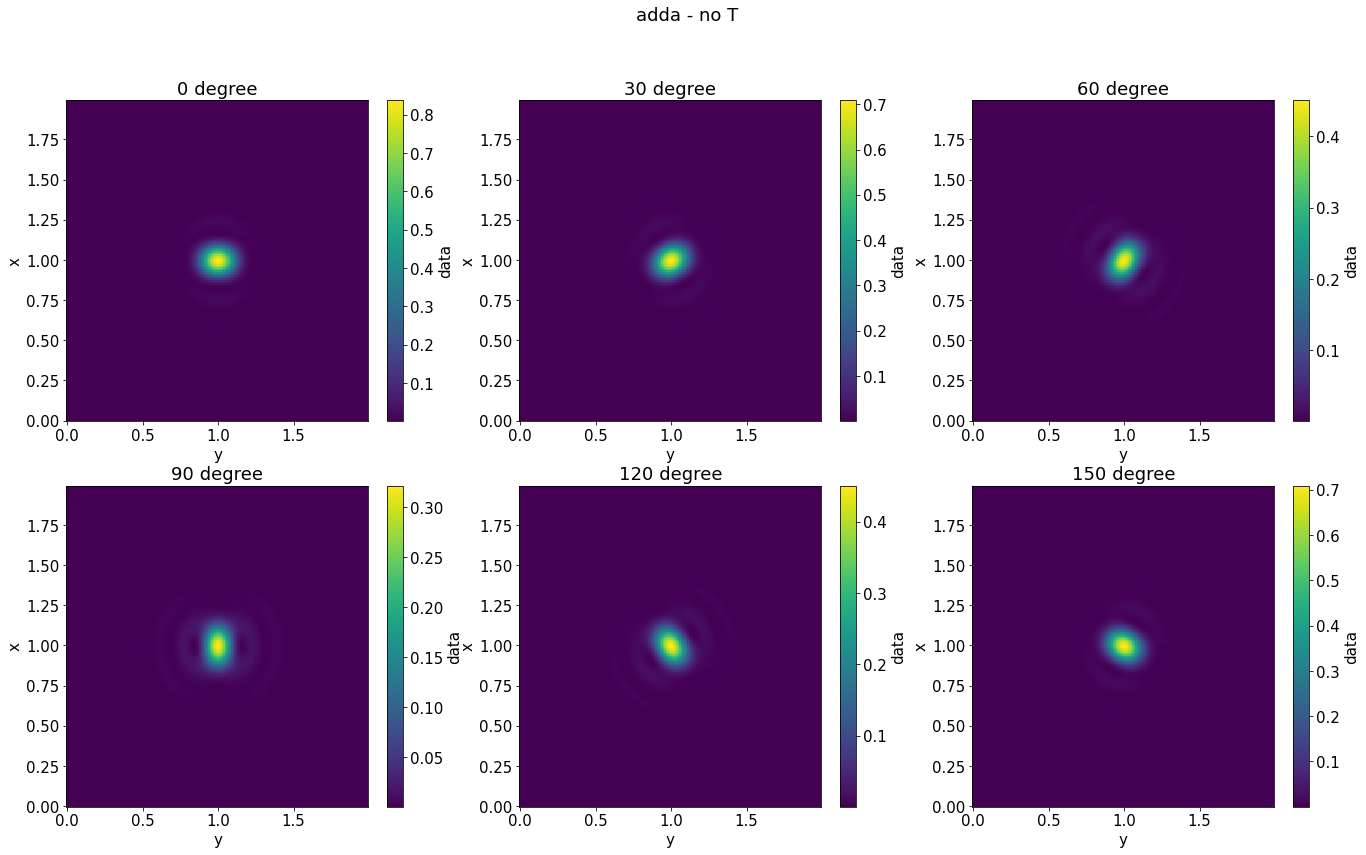

In [16]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - no T')
plt.show()

In [49]:
ell = Ellipsoid(r = (0.1,0.05,0.05), n = 0.035+1j*2.809, center = (0.5,0.5,0))
detector = hp.detector_grid(100, .01)

len_dda = Lens(1.38, DDA(use_gpu=True, suppress_C_output=False, transpose_matr=False, max_dpl_size=0.002))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.02632'
Geometry saved to file
box dimensions: 100x50x49
lambda: 0.3458646617   Dipoles/lambda: 172.932
Required relative residual norm: 1e-05
Total number of occupied dipoles: 130512


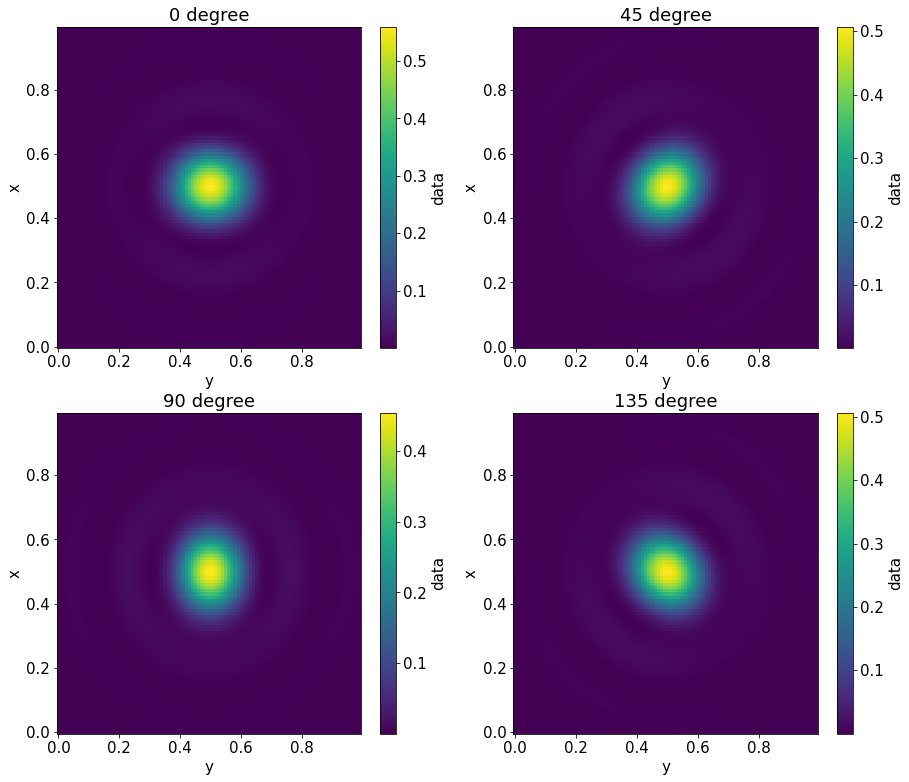

In [50]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,45,90,135]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
plt.show()

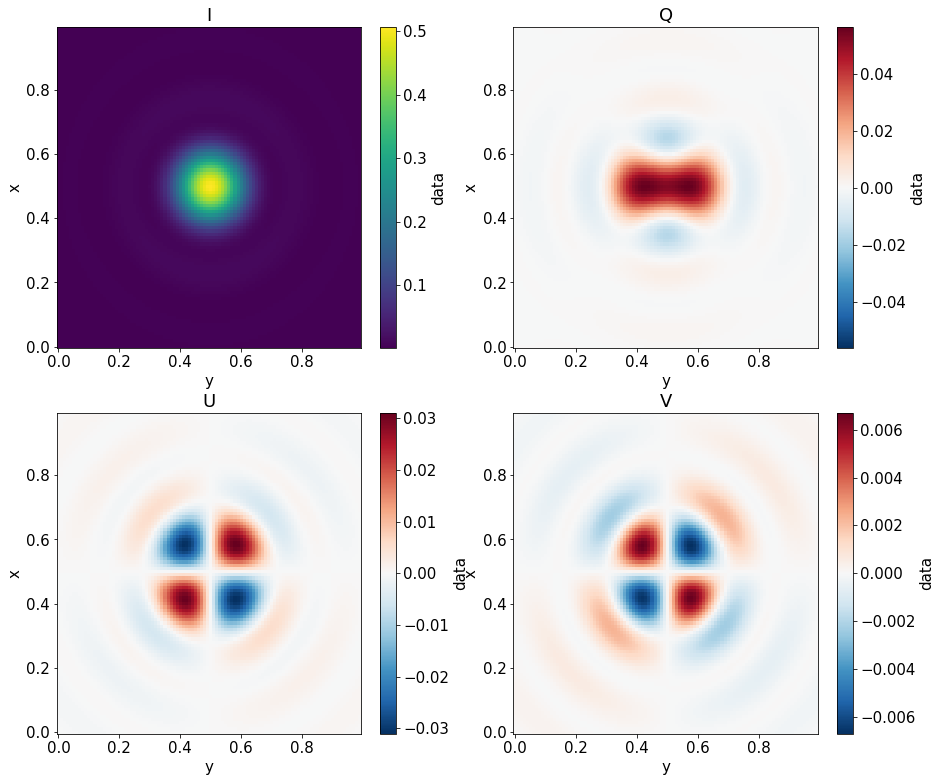

In [51]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
# plt.savefig('cdr/adda_biellip_unpol.png')
plt.show()

### Adda-T (default)

In [17]:
%%time
# ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
# ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
# biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))
ell = Ellipsoid(r = (0.1,0.05,0.05), n = 0.05+1j*2.1, center = (1,1,0))
detector = hp.detector_grid(200, .01)

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
# bond = np.array(biel.bounds)
# c = biel.center
# for i,b in enumerate(bond):
#     bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
#     bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
# biel.indicators.bound = bond

len_dda = Lens(1.38, DDA(use_gpu=True, transpose_matr=True, suppress_C_output=False))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.4, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g20_m0.03759'
Geometry saved to file
box dimensions: 20x9x9
lambda: 0.3007518797   Dipoles/lambda: 30.0752
Required relative residual norm: 1e-05
Total number of occupied dipoles: 988
Searchi

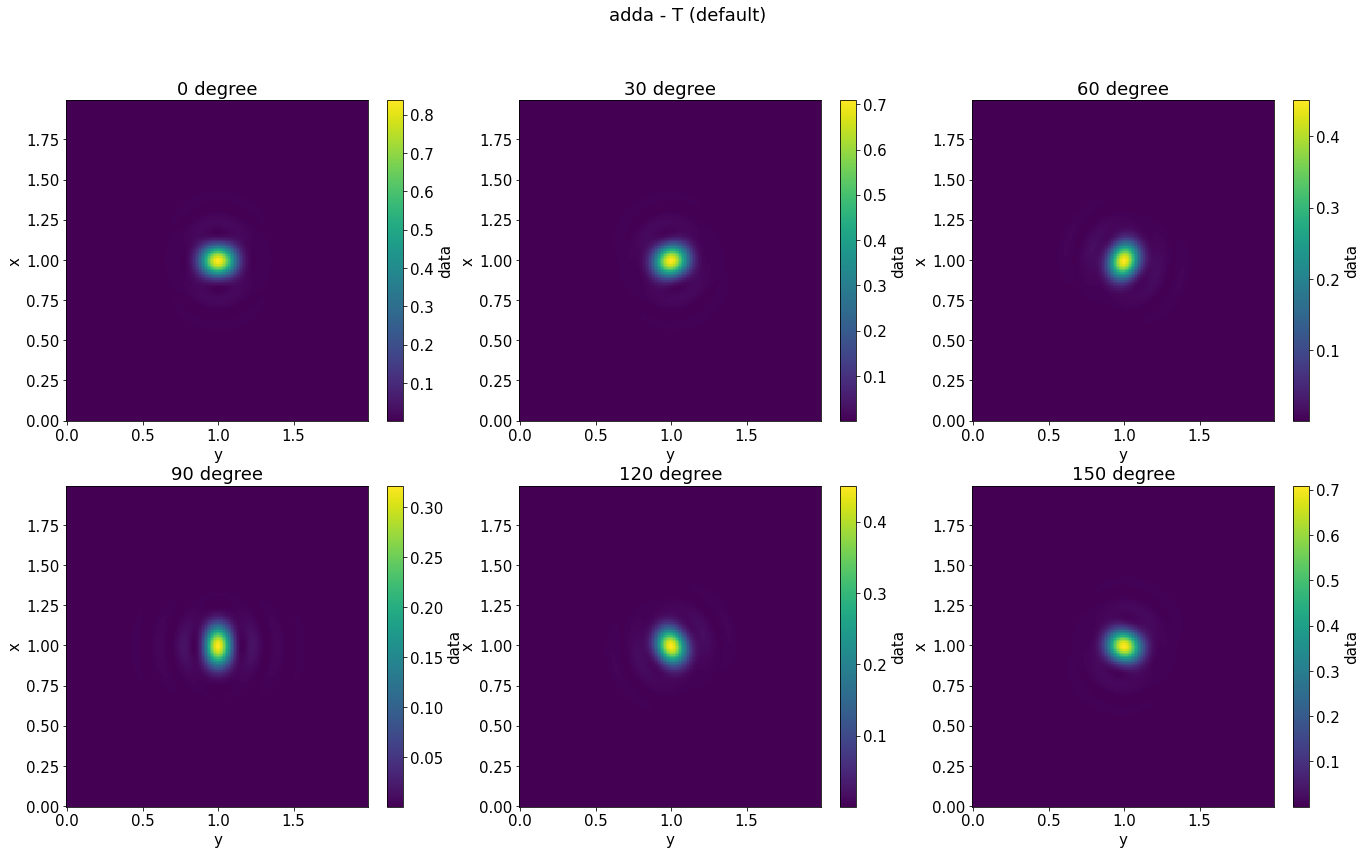

In [18]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - T (default)')
plt.show()

In [20]:
holo_unp

<xarray.DataArray 'data' (S: 4, x: 200, y: 200, z: 1)>
array([[[[ 3.71984420e-06],
         [ 2.79932479e-06],
         [ 5.29800313e-06],
         ...,
         [ 1.10973183e-05],
         [ 5.29800476e-06],
         [ 2.79932342e-06]],

        [[ 2.82373250e-06],
         [ 5.30969063e-06],
         [ 1.11671097e-05],
         ...,
         [ 1.99944113e-05],
         [ 1.11671110e-05],
         [ 5.30969227e-06]],

        [[ 5.23766125e-06],
         [ 1.10859707e-05],
         [ 1.99755238e-05],
         ...,
...
         ...,
         [ 2.28147632e-05],
         [ 1.50024408e-05],
         [ 8.07011068e-06]],

        [[ 9.22326833e-07],
         [-2.67526809e-06],
         [-8.09602501e-06],
         ...,
         [ 1.49084610e-05],
         [ 8.09602731e-06],
         [ 2.67527153e-06]],

        [[ 2.39931867e-06],
         [ 8.80985383e-07],
         [-2.67313141e-06],
         ...,
         [ 7.99207765e-06],
         [ 2.67313485e-06],
         [-8.80981943e-07]]]])
Coordinates:
  * S        (S) <U1 'I' 'Q' 'U' 'V'
  * x        (x) float64 0.0 0.01 0.02 0.03 0.04 ... 1.95 1.96 1.97 1.98 1.99
  * y        (y) float64 0.0 0.01 0.02 0.03 0.04 ... 1.95 1.96 1.97 1.98 1.99
  * z        (z) int64 0

In [46]:
ell = Ellipsoid(r = (0.1,0.05,0.05), n = 0.035+1j*2.809, center = (0.5,0.5,0))
detector = hp.detector_grid(100, .01)

len_dda = Lens(1.38, DDA(use_gpu=True, suppress_C_output=False, transpose_matr=True, max_dpl_size=0.002))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = newsdm_utils.calc_unpolar(detector, scat=ell, medium_index=1.33, illum_wavelen=0.460, theory=len_dda)

ADDA v.1.4.0-alpha (6972bf6)
Sequential version
Built with GNU compilers version 7.5.0 (64-bit)
Extra build options: none

Copyright (C) 2006-2019 ADDA contributors
This program is free software; you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the Free Software
Foundation; either version 3 of the License, or (at your option) any later
version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY
WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A
PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with
this program. If not, see <http://www.gnu.org/licenses/>.
all data is saved in 'run000_read_g100_m0.02632'
Geometry saved to file
box dimensions: 100x50x49
lambda: 0.3458646617   Dipoles/lambda: 172.932
Required relative residual norm: 1e-05
Total number of occupied dipoles: 130512


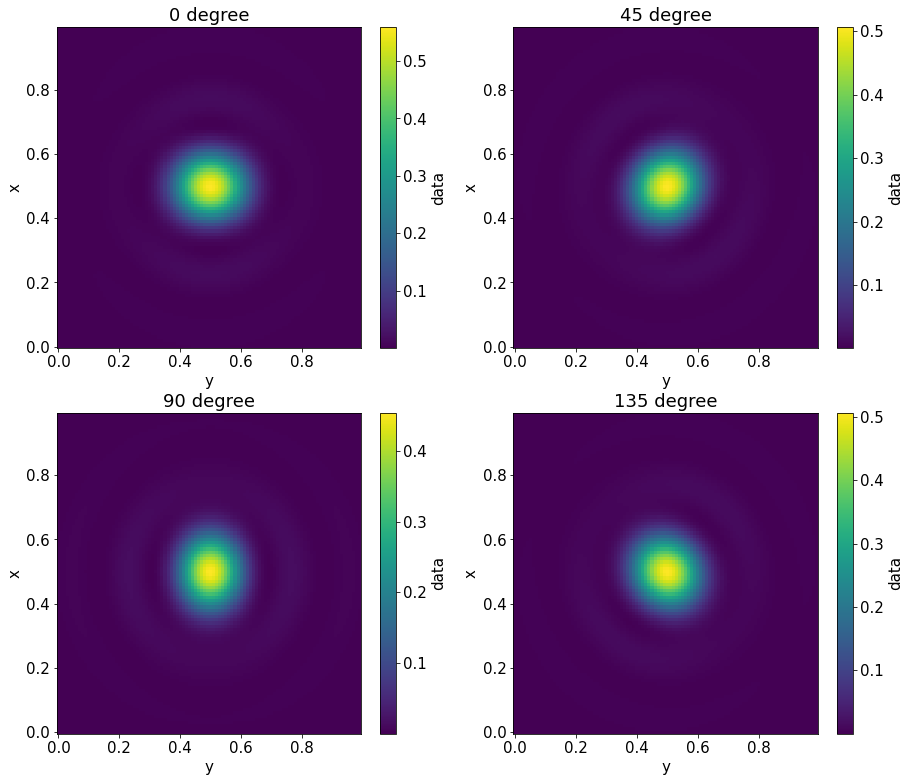

In [47]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,45,90,135]):
    th *= np.pi/180
    holo_th = newsdm_utils.apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
plt.show()

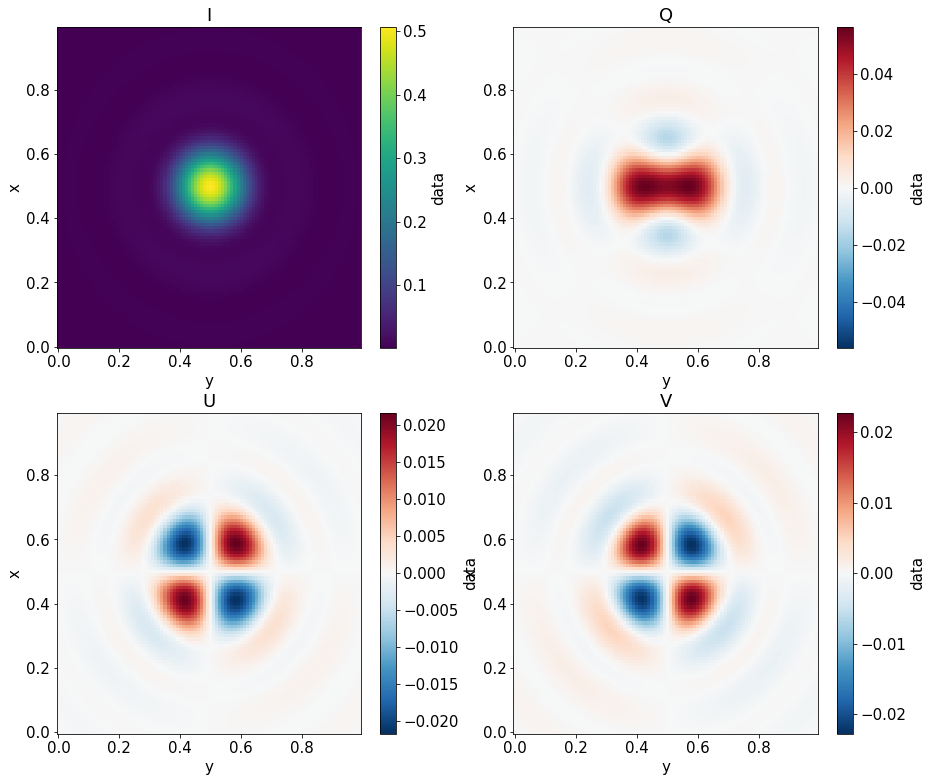

In [48]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 2, figsize=(15, 13))
axes = np.ravel(axes)
holo_unp.sel(S='I').plot(ax=axes[0])
axes[0].set_title('I')
holo_unp.sel(S='Q').plot(ax=axes[1])
axes[1].set_title('Q')
holo_unp.sel(S='U').plot(ax=axes[2])
axes[2].set_title('U')
holo_unp.sel(S='V').plot(ax=axes[3])
axes[3].set_title('V')
# plt.savefig('cdr/adda_biellip_unpol.png')
plt.show()

# OLD

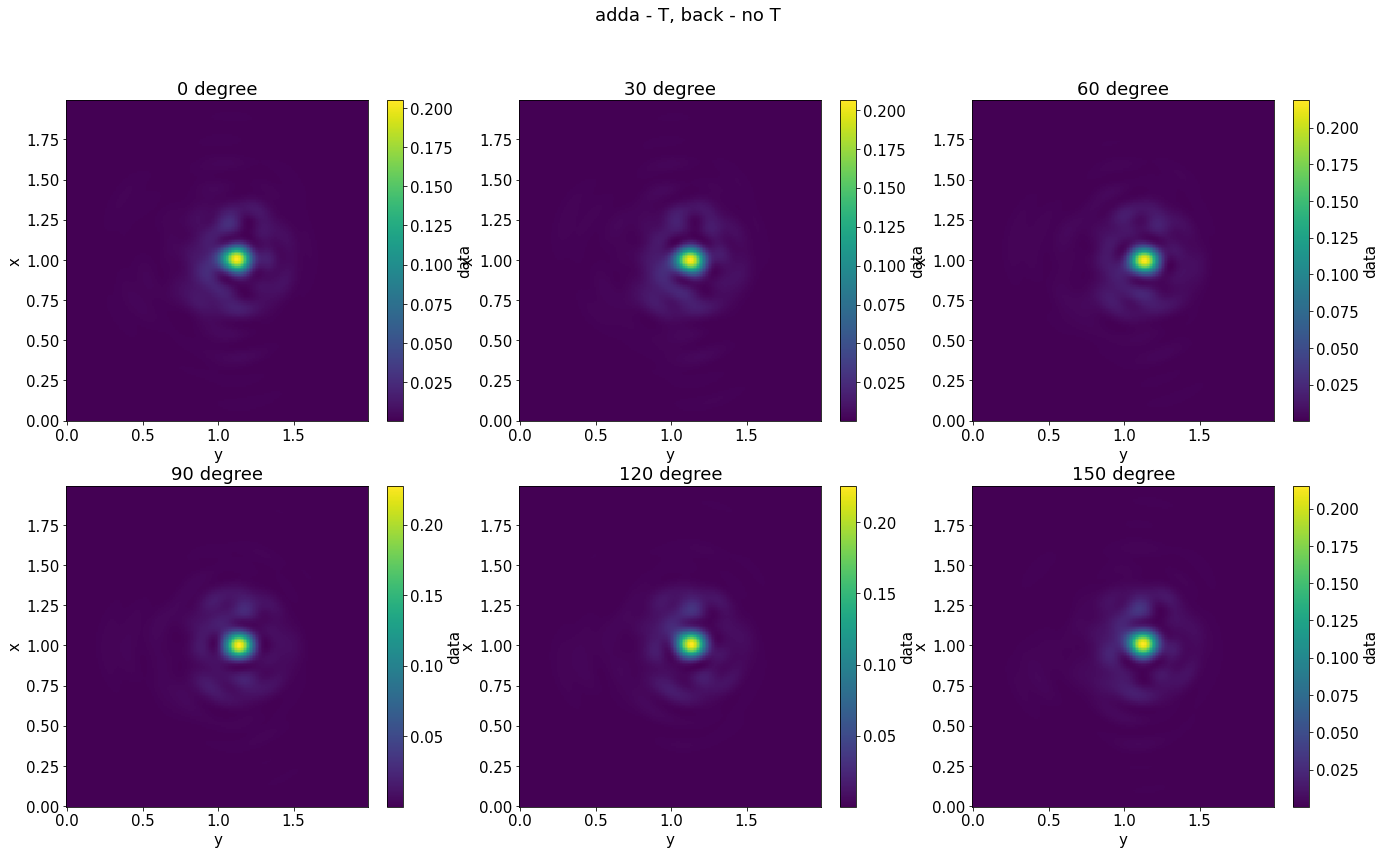

In [7]:
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True)))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = calc_unpolar(detector, scat=biel, medium_index=1.515, illum_wavelen=0.4, theory=len_dda)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - T, back - no T')
plt.show()

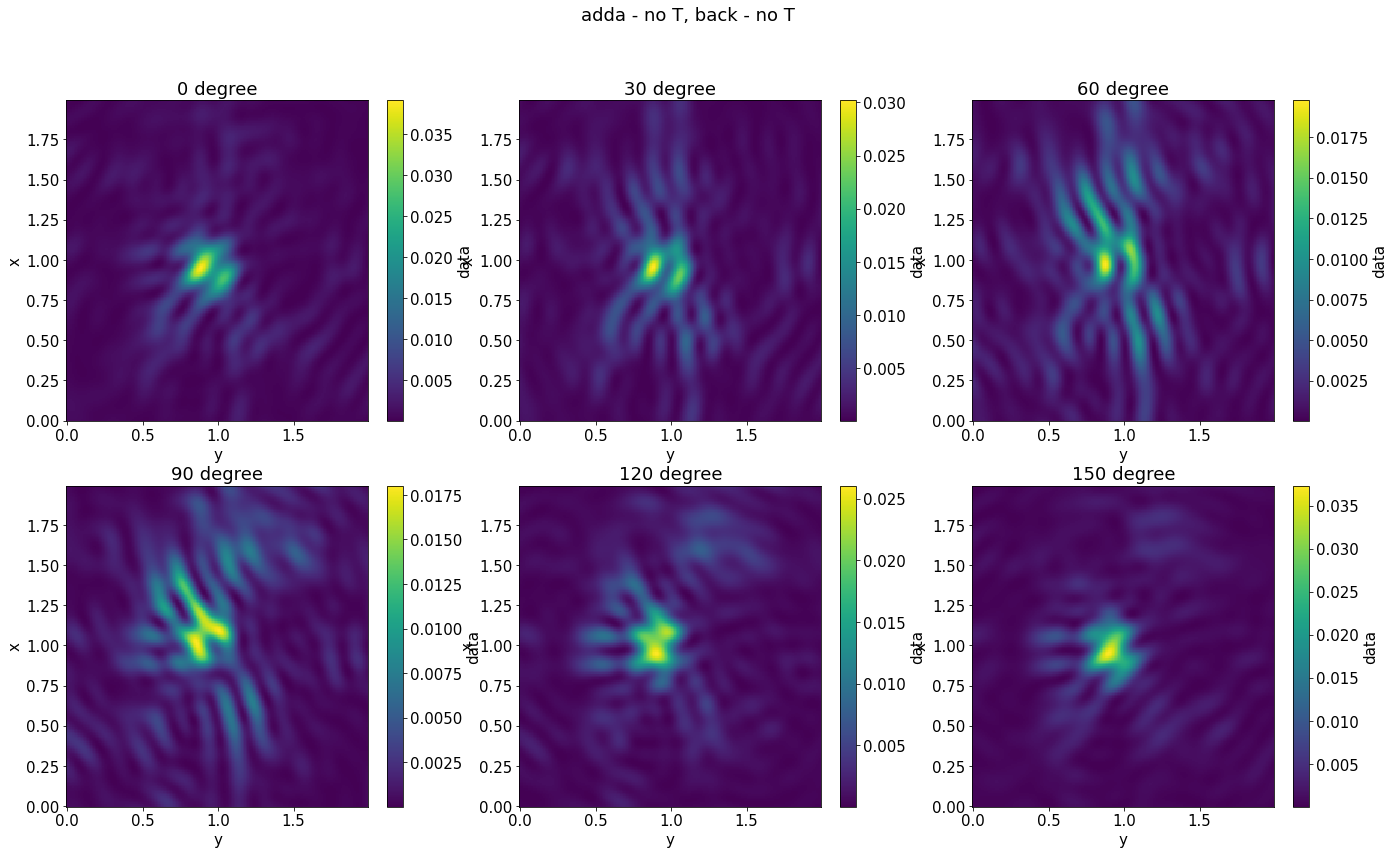

CPU times: user 1min 13s, sys: 8.5 s, total: 1min 22s
Wall time: 22.9 s


In [9]:
%%time
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True)))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = calc_unpolar(detector, scat=biel, medium_index=1.515, illum_wavelen=0.4, theory=len_dda)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - no T, back - no T')
plt.show()

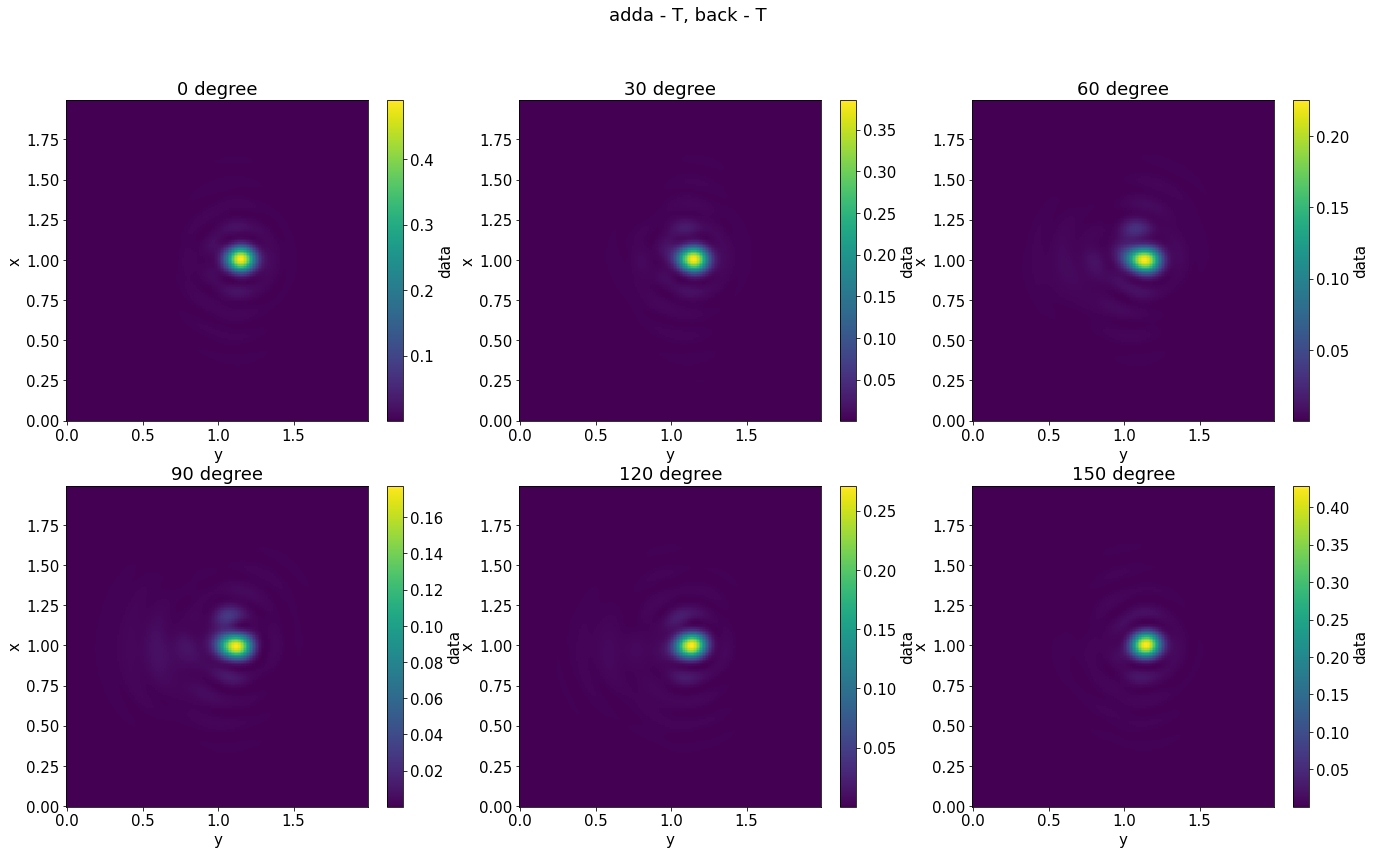

In [14]:
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True)))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = calc_unpolar(detector, scat=biel, medium_index=1.515, illum_wavelen=0.4, theory=len_dda)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - T, back - T')
plt.show()

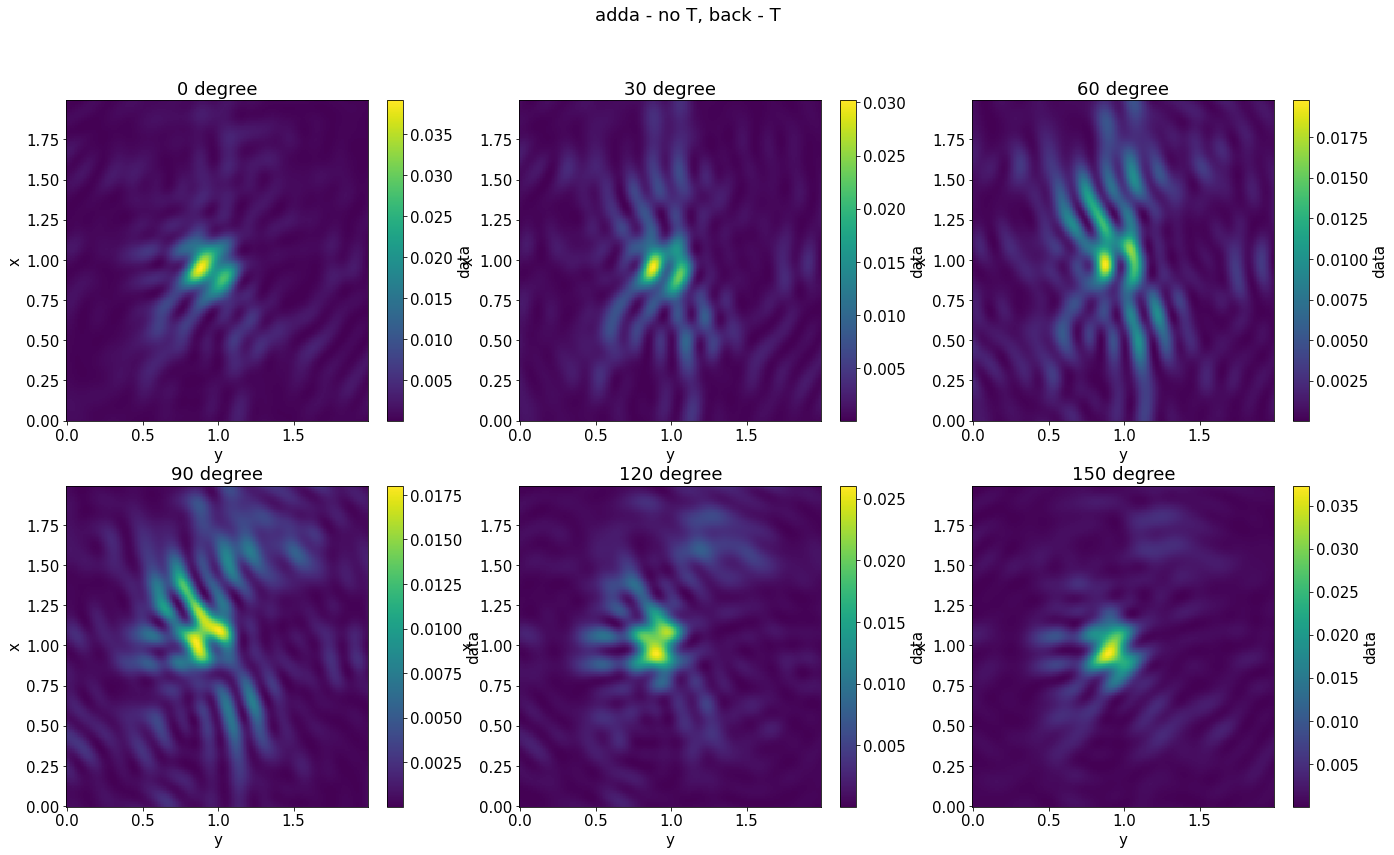

In [11]:
ell1 = Ellipsoid(r = (0.1,0.05,0.05), center = (0,-0.1,0))
ell2 = Ellipsoid(r = (0.05,0.1,0.5), center = (0,0.15,0))
detector = hp.detector_grid(200, .01)
biel = Scatterer(lambda point: np.logical_or(ell1.contains(point), ell2.contains(point)), n = 0.05+1j*2.1, center = (1, 1, 0))

# changing bounds by hand, since there is nothing in the center
# and default algorithm will fail
bond = np.array(biel.bounds)
c = biel.center
for i,b in enumerate(bond):
    bond[i,0] = min(ell1.bounds[i][0], ell2.bounds[i][0])
    bond[i,1] = max(ell1.bounds[i][1], ell2.bounds[i][1])
biel.indicators.bound = bond

len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True)))#, addacmd=['-orient',str(th),'0','0']))
holo_unp = calc_unpolar(detector, scat=biel, medium_index=1.515, illum_wavelen=0.4, theory=len_dda)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
for i,th in enumerate([0,30,60,90,120,150]):
    th *= np.pi/180
    holo_th = apply_pol(holo_unp, th) ###
    holo_th.plot(ax=axes[i])
    axes[i].set_title(str(round(th*180/np.pi))+' degree')
#plt.savefig('cdr/adda_biellip_pol.png')
fig.suptitle('adda - no T, back - T')
plt.show()

### filaments from the ROOT file

In [32]:
with open('/home/scanner-ml/ML-drive/Artem/Python/NEWS/ADDA/sandbox/tests/filament/fils_table.txt','r') as filtxt:
    tmp_fil = filtxt.read()
tmp_fil = tmp_fil.split('\n')[1:-2]
tmp_cols = [t.strip() for t in tmp_fil[0].split('*')[2:-1]]
tmp_fil = [t.split('*')[2:-1] for t in tmp_fil[2:]]
tmp_ar = np.array([[t.strip() for t in tmp_fil[i]] for i in range(len(tmp_fil))])
tmp_cols

['Instance',
 'event',
 'ncrs',
 'icrs',
 'nlim',
 'idfil',
 'crfil',
 'xfil',
 'yfil',
 'zfil']

In [33]:
import pandas as pd
tmp_ar = pd.DataFrame(tmp_ar, columns=tmp_cols)
tmp_ar = tmp_ar.dropna(subset=['xfil','yfil','zfil'])
for col in tmp_ar.columns:
    tmp_ar.loc[:,col] = pd.to_numeric(tmp_ar[col], errors='coerce')
tmp_ar = tmp_ar.dropna(subset=['xfil','yfil','zfil'])
tmp_ar.head()

Instance  event  ncrs  icrs  nlim  idfil  crfil      xfil      yfil  \
2         0      2     1   0.0   2.0    1.0    2.0 -1532.746 -1662.427   
3         1      2     1   NaN   NaN    1.0    2.0 -1506.281 -1582.114   
4         2      2     1   NaN   NaN    1.0    2.0 -1519.259 -1556.701   
5         3      2     1   NaN   NaN    1.0    2.0 -1621.419 -1601.352   
6         4      2     1   NaN   NaN    1.0    2.0 -1674.797 -1533.618   

        zfil  
2  771.48089  
3  864.37268  
4  840.24224  
5  996.71777  
6  884.01178

In [34]:
tmp_ar.shape

(17271, 10)

In [35]:
tmp_ar.to_csv('fil_table.csv')
tmp_csv = pd.read_csv('fil_table.csv', index_col=0)
tmp_csv.head(18)

Instance  event  ncrs  icrs  nlim  idfil  crfil      xfil      yfil  \
2          0      2     1   0.0   2.0    1.0    2.0 -1532.746 -1662.427   
3          1      2     1   NaN   NaN    1.0    2.0 -1506.281 -1582.114   
4          2      2     1   NaN   NaN    1.0    2.0 -1519.259 -1556.701   
5          3      2     1   NaN   NaN    1.0    2.0 -1621.419 -1601.352   
6          4      2     1   NaN   NaN    1.0    2.0 -1674.797 -1533.618   
7          5      2     1   NaN   NaN    2.0    2.0 -1551.587 -1663.560   
8          6      2     1   NaN   NaN    2.0    2.0 -1568.998 -1620.329   
9          7      2     1   NaN   NaN    2.0    2.0 -1493.090 -1669.889   
10         0      3     1   0.0   2.0    1.0    7.0 -1897.037 -1486.146   
11         1      3     1   NaN   NaN    1.0    7.0 -1913.615 -1478.164   
12         2      3     1   NaN   NaN    1.0    7.0 -1964.094 -1574.975   
13         3      3     1   NaN   NaN    1.0    7.0 -1935.682 -1576.993   
14         4      3     1   NaN   NaN    1.0    7.0 -1954.286 -1536.152   
15         5      3     1   NaN   NaN    2.0    7.0 -1844.549 -1480.947   
16         6      3     1   NaN   NaN    2.0    7.0 -1752.337 -1452.762   
25         0     12     1   0.0   2.0    1.0    6.0 -1583.917 -1812.067   
26         1     12     1   NaN   NaN    1.0    6.0 -1572.029 -1734.856   
27         2     12     1   NaN   NaN    2.0    6.0 -1570.395 -1844.635   

         zfil  
2   771.48089  
3   864.37268  
4   840.24224  
5   996.71777  
6   884.01178  
7   771.98010  
8   825.08422  
9   839.61743  
10  788.73938  
11  836.55767  
12  714.48437  
13  641.28686  
14  615.19213  
15  735.78936  
16  704.32067  
25  696.60376  
26  642.64038  
27  747.85180

In [36]:
tmp_gr = tmp_ar.groupby('event')
for gr, gr_ids in tmp_gr:
    print(gr)
    gr_event = gr_ids.groupby(['crfil','idfil'])
    for g, gr_ar in gr_event:
        print(g)
        print(gr_ar)
    #print(type(gr_ids))

2
(2.0, 1.0)
   Instance  event  ncrs  icrs  nlim  idfil  crfil      xfil      yfil  \
2         0      2     1   0.0   2.0    1.0    2.0 -1532.746 -1662.427   
3         1      2     1   NaN   NaN    1.0    2.0 -1506.281 -1582.114   
4         2      2     1   NaN   NaN    1.0    2.0 -1519.259 -1556.701   
5         3      2     1   NaN   NaN    1.0    2.0 -1621.419 -1601.352   
6         4      2     1   NaN   NaN    1.0    2.0 -1674.797 -1533.618   

        zfil  
2  771.48089  
3  864.37268  
4  840.24224  
5  996.71777  
6  884.01178  
(2.0, 2.0)
   Instance  event  ncrs  icrs  nlim  idfil  crfil      xfil      yfil  \
7         5      2     1   NaN   NaN    2.0    2.0 -1551.587 -1663.560   
8         6      2     1   NaN   NaN    2.0    2.0 -1568.998 -1620.329   
9         7      2     1   NaN   NaN    2.0    2.0 -1493.090 -1669.889   

        zfil  
7  771.98010  
8  825.08422  
9  839.61743  
3
(7.0, 1.0)
    Instance  event  ncrs  icrs  nlim  idfil  crfil      xfil      yfil

In [37]:
filaments = {}
tmp_gr = tmp_ar.groupby('event')
for ev, ev_ids in tmp_gr:
    filaments[ev] = [f.loc[:,['xfil','yfil','zfil']].values for crid, f in ev_ids.groupby(['crfil','idfil'])]

In [38]:
len(filaments.keys())

2766

In [39]:
list(filaments.keys())[:5]

[2, 3, 12, 13, 15]

In [40]:
filament_n = []
for k in filaments.keys():
    filament_n.append([k,len(filaments[k])])
filament_n = np.array(filament_n)

* HoloPy filaments

In [41]:
def sph_rule(coord,R=1,delta=1):
    return np.sum((coord*delta)**2, axis=-1)<R**2


def line_rule(coord, p1=None, p2=None, delta=1.0, R=20):
    p = coord*delta
    l = p-p1; l12 = p2-p1
    d1 = -np.dot(p2-p1,p1); d2 = -np.dot(p2-p1, p2)
    return ((np.linalg.norm(np.cross(l,l12), axis=-1)/np.linalg.norm(l12, axis=-1)<R) * (np.dot(p,l12)+d2<0) * (np.dot(p,l12)+d1>0)) + (np.linalg.norm(l, axis=-1)<R) + (np.linalg.norm(p-p2, axis=-1)<R)# + (np.linalg.norm(l, axis=-1)<delta)

def filament_rule(coord, fil_coord, R=1):
    fill = np.zeros(coord.shape[:-1], dtype=bool)
    for i in range(fil_coord.shape[0]-1): 
        fill += line_rule(coord, p1=fil_coord[i], p2=fil_coord[i+1], delta=1, R=R)
    return fill

### 1 filament

In [42]:
R = 0.01
fil_center = [0,0,0]
fil_bounds = [[],[],[]]

fil_coord = filaments[17].copy()

for i in range(len(fil_coord)): fil_coord[i] = fil_coord[i][::-1]/1000

for i in range(3): 
    fil_bounds[i] = [min([f[:,i].min() for f in fil_coord])-R,max([f[:,i].max() for f in fil_coord])+R]
    fil_center[i] = sum(fil_bounds[i])/2
    for j in range(2): fil_bounds[i][j] -= fil_center[i]
for i in range(len(fil_coord)): fil_coord[i] -= fil_center

from holopy.scattering.scatterer import Indicators
indi = Indicators(lambda x: np.sum([filament_rule(x, f, R=R) for f in fil_coord], axis=0, dtype=bool), bound=fil_bounds)
copa_fil = Scatterer(indi, n=0.05+1j*2.1, center=(1,1,0))

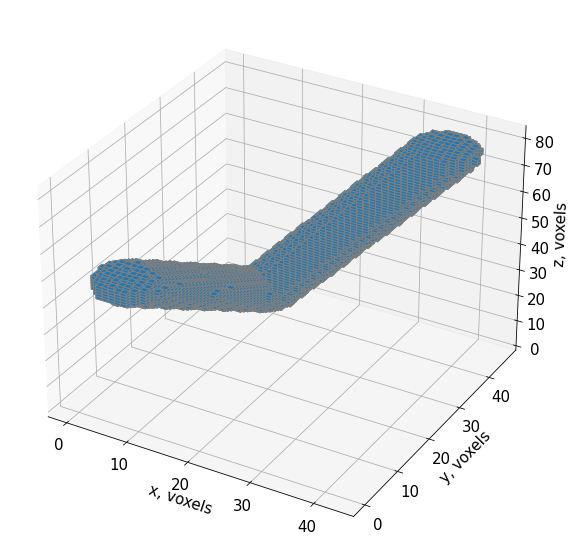

CPU times: user 13.8 s, sys: 194 ms, total: 14 s
Wall time: 13.7 s


In [43]:
%%time
#from holopy.scattering.scatterer import Indicators
#indi = Indicators(lambda x: sph_rule(x, R=0.5, delta=1))
#copa_sph = Scatterer(indi, n=1.5, center=(1,1,0))

from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x, voxels")
    ax.set_ylabel("y, voxels")
    ax.set_zlabel("z, voxels")
    ax.grid(grid)
    return ax

filam = np.array(copa_fil.voxelate(spacing=0.002), dtype=bool)

#filled = np.zeros((filam[:,0].max()+1, filam[:,1].max()+1, filam[:,2].max()+1), dtype=bool)
#for c in filam:
#    filled[c[0],c[1],c[2]] = True

ax = make_ax(True)
ax.voxels(filam, edgecolors='gray', shade=False)
plt.savefig('cdr/adda_1fil_scheme.png')
plt.show()

In [44]:
fil_coord

[array([[-0.0321055 , -0.035492  ,  0.00764646],
        [-0.0270745 ,  0.035492  , -0.07250878],
        [ 0.0321055 ,  0.034707  ,  0.07250877]])]

In [45]:
fil_center

[-1.6467785, -1.963696, 0.25323075500000003]

In [46]:
fil_bounds

[[-0.04210550000000013, 0.04210549999999991],
 [-0.045491999999999866, 0.04549200000000009],
 [-0.08250877500000003, 0.08250877499999998]]

In [47]:
copa_fil.bounds

[(0.9578944999999999, 1.0421055),
 (0.9545080000000001, 1.045492),
 (-0.08250877500000003, 0.08250877499999998)]

In [48]:
import numpy as np
from holopy.scattering.theory.scatteringtheory import ScatteringTheory

class Backscattered(ScatteringTheory):
    def __init__(self, theory):
        self.theory = theory

    def can_handle(self, scatterer):
        return self.theory.can_handle(scatterer)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        r, theta, phi = pos
        theta_backscattered = np.pi - theta
        pos_backscattered = np.array([r, theta_backscattered, phi])

        args = (scatterer, pos_backscattered, medium_wavevec, medium_index)
        scat_matrices = np.array(self.theory.raw_scat_matrs(*args))

        # account for coordinate change in decomposition of incoming
        # light into theta, phi components:
        scat_matrices[:, 0, 0] *= -1
        scat_matrices[:, 0, 1] *= -1  # FIXME is it this or the transpose? NOW IT IS

        return scat_matrices

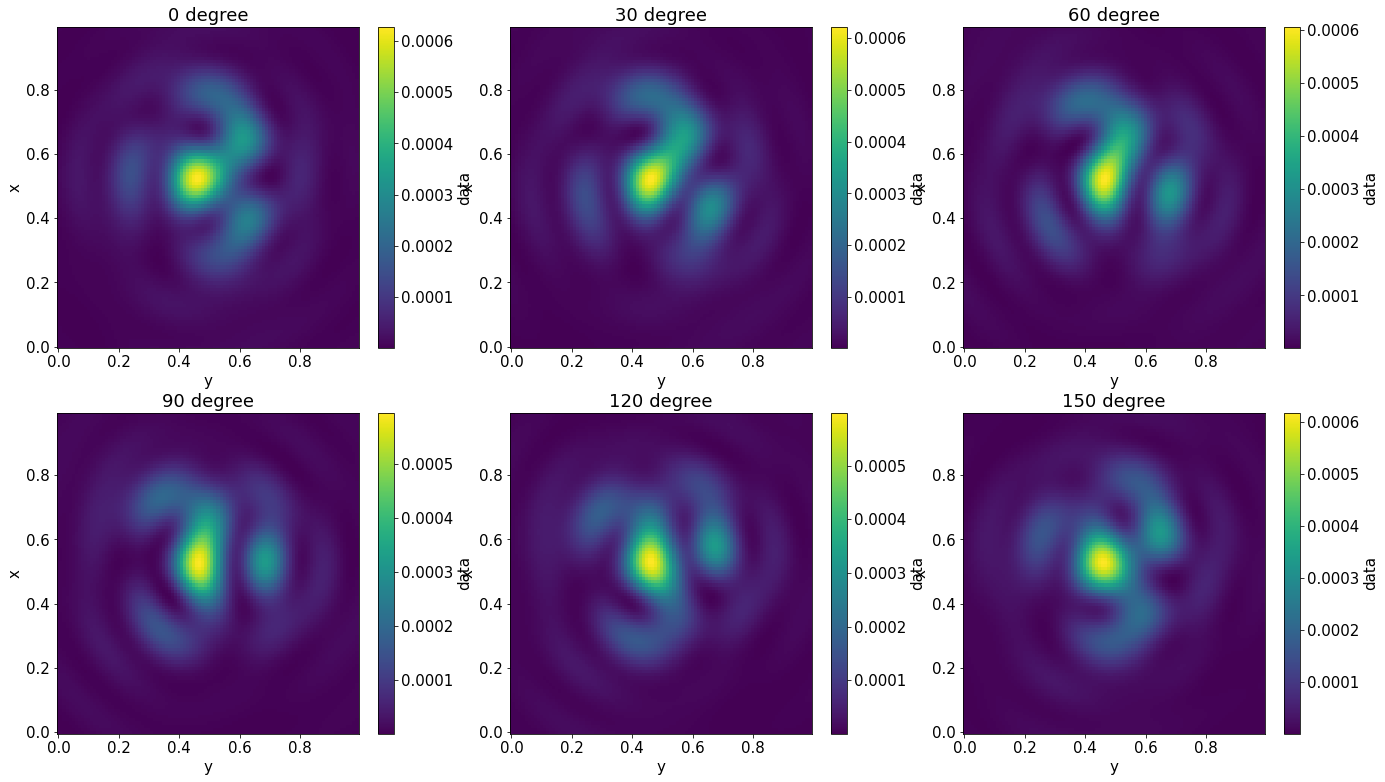

CPU times: user 20.3 s, sys: 1.5 s, total: 21.9 s
Wall time: 1min 17s


In [49]:
%%time
copa_fil = Scatterer(indi, n=0.0345+1j*2.859, center=(0.5,0.5,0))
detector = hp.detector_grid(100, .01)

holo_fil = {}
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, max_dpl_size=0.002)))
holo_unp = calc_unpolar(detector, copa_fil, medium_index=1.515, illum_wavelen=0.465, theory=len_dda)
for i,th in enumerate([0,30,60,90,120,150]):
    #th *= np.pi/180
    holo_fil[th] = apply_pol(holo_unp, th*np.pi/180)
    holo_fil[th].plot(ax=axes[i])
    axes[i].set_title(str(th)+' degree')
plt.show()

### Transposed

In [50]:
import numpy as np
from holopy.scattering.theory.scatteringtheory import ScatteringTheory

class Backscattered(ScatteringTheory):
    def __init__(self, theory):
        self.theory = theory

    def can_handle(self, scatterer):
        return self.theory.can_handle(scatterer)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        r, theta, phi = pos
        theta_backscattered = np.pi - theta
        pos_backscattered = np.array([r, theta_backscattered, phi])

        args = (scatterer, pos_backscattered, medium_wavevec, medium_index)
        scat_matrices = np.array(self.theory.raw_scat_matrs(*args))

        # account for coordinate change in decomposition of incoming
        # light into theta, phi components:
        scat_matrices[:, 0, 0] *= -1
        scat_matrices[:, 1, 0] *= -1  # FIXME is it this or the transpose? NOW IT IS

        return scat_matrices

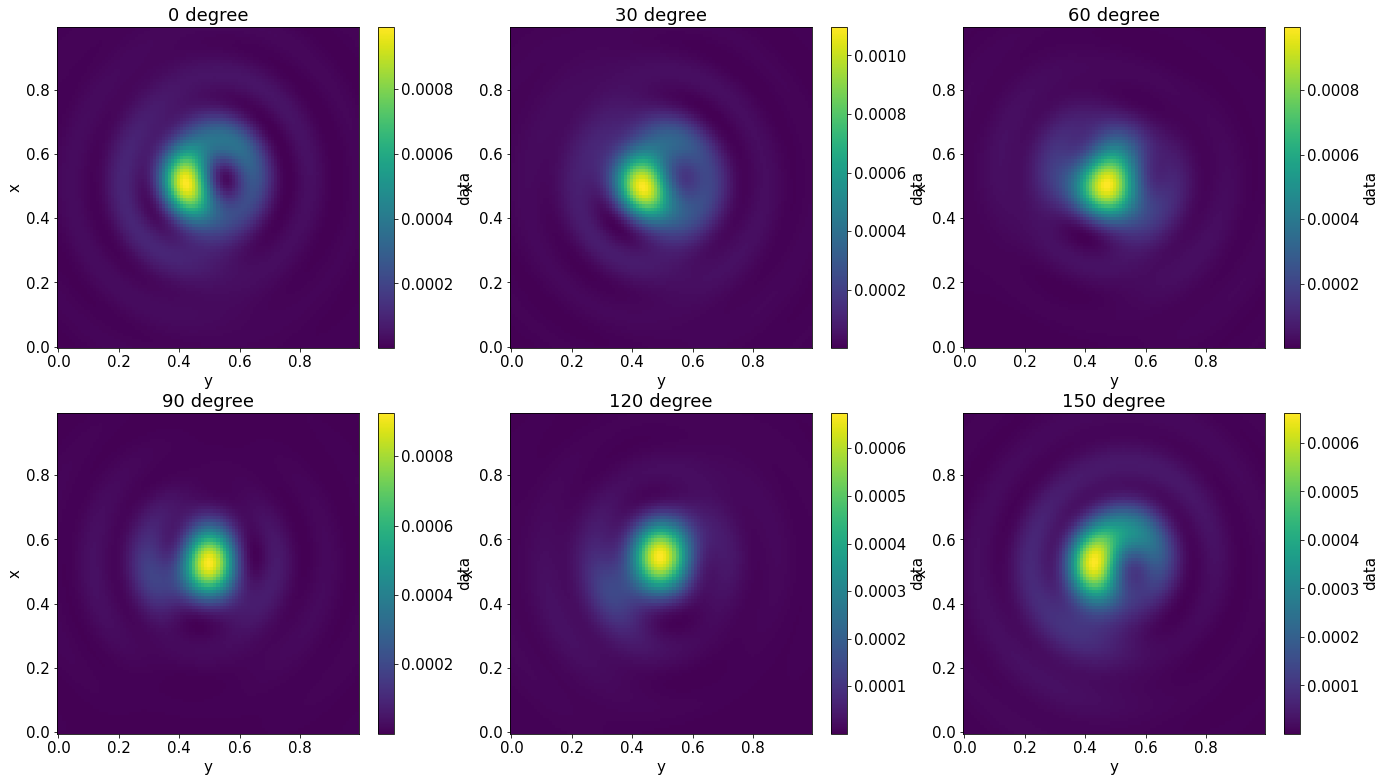

CPU times: user 20.3 s, sys: 1.23 s, total: 21.5 s
Wall time: 1min 17s


In [51]:
%%time
copa_fil = Scatterer(indi, n=0.0345+1j*2.859, center=(0.5,0.5,0))
detector = hp.detector_grid(100, .01)

holo_fil = {}
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, max_dpl_size=0.002)))
holo_unp = calc_unpolar(detector, copa_fil, medium_index=1.515, illum_wavelen=0.465, theory=len_dda)
for i,th in enumerate([0,30,60,90,120,150]):
    #th *= np.pi/180
    holo_fil[th] = apply_pol(holo_unp, th*np.pi/180)
    holo_fil[th].plot(ax=axes[i])
    axes[i].set_title(str(th)+' degree')
plt.show()

### Diagonal

In [52]:
import numpy as np
from holopy.scattering.theory.scatteringtheory import ScatteringTheory

class Backscattered(ScatteringTheory):
    def __init__(self, theory):
        self.theory = theory

    def can_handle(self, scatterer):
        return self.theory.can_handle(scatterer)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        r, theta, phi = pos
        theta_backscattered = np.pi - theta
        pos_backscattered = np.array([r, theta_backscattered, phi])

        args = (scatterer, pos_backscattered, medium_wavevec, medium_index)
        scat_matrices = np.array(self.theory.raw_scat_matrs(*args))

        # account for coordinate change in decomposition of incoming
        # light into theta, phi components:
        scat_matrices[:, 0, 0] *= -1
        scat_matrices[:, 1, 1] *= -1  # FIXME is it this or the transpose? NOW IT IS

        return scat_matrices

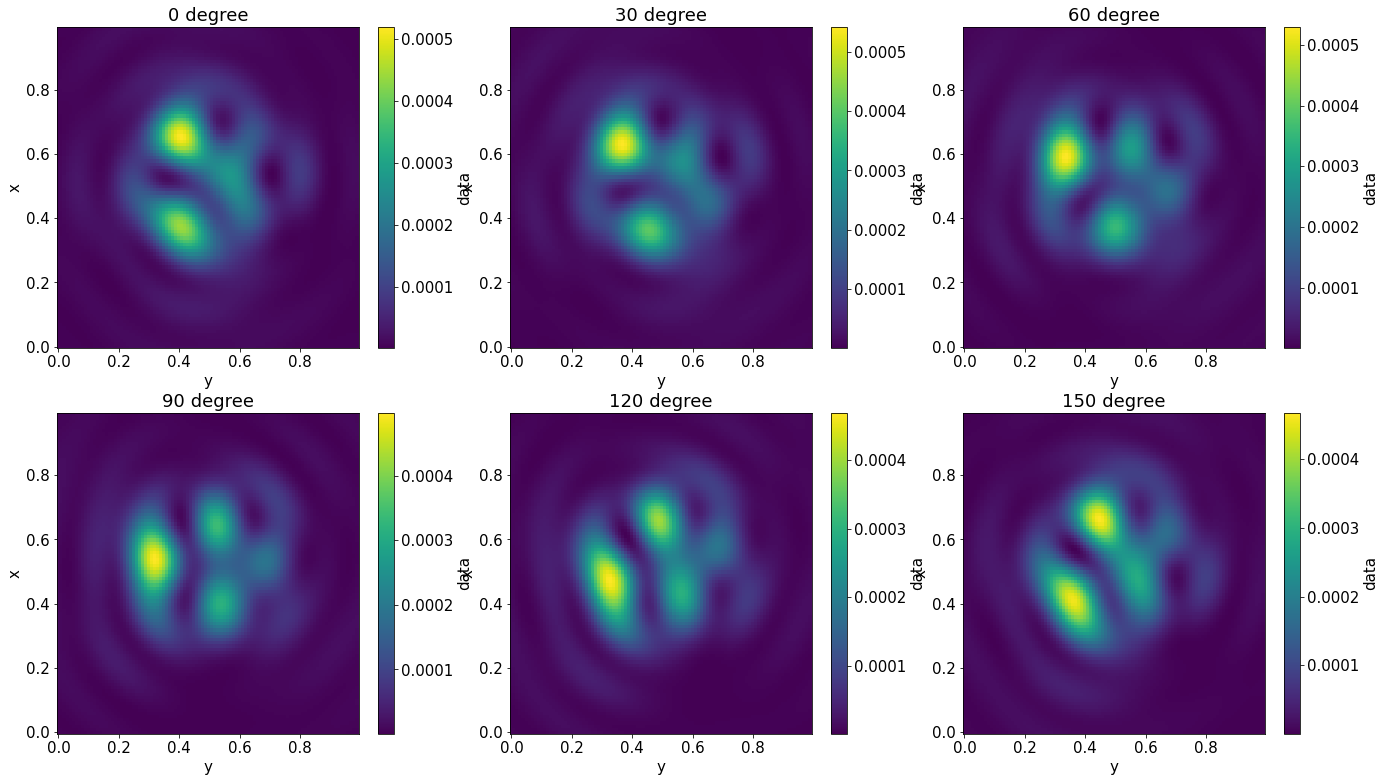

CPU times: user 20 s, sys: 1.43 s, total: 21.4 s
Wall time: 1min 17s


In [53]:
%%time
copa_fil = Scatterer(indi, n=0.0345+1j*2.859, center=(0.5,0.5,0))
detector = hp.detector_grid(100, .01)

holo_fil = {}
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, max_dpl_size=0.002)))
holo_unp = calc_unpolar(detector, copa_fil, medium_index=1.515, illum_wavelen=0.465, theory=len_dda)
for i,th in enumerate([0,30,60,90,120,150]):
    #th *= np.pi/180
    holo_fil[th] = apply_pol(holo_unp, th*np.pi/180)
    holo_fil[th].plot(ax=axes[i])
    axes[i].set_title(str(th)+' degree')
plt.show()

### 2 filament

In [54]:
R = 0.01
fil_center = [0,0,0]
fil_bounds = [[],[],[]]

fil_coord = filaments[3].copy()

for i in range(len(fil_coord)): fil_coord[i] = fil_coord[i][::-1]/1000

for i in range(3): 
    fil_bounds[i] = [min([f[:,i].min() for f in fil_coord])-R,max([f[:,i].max() for f in fil_coord])+R]
    fil_center[i] = sum(fil_bounds[i])/2
    for j in range(2): fil_bounds[i][j] -= fil_center[i]
for i in range(len(fil_coord)): fil_coord[i] -= fil_center

from holopy.scattering.scatterer import Indicators
indi = Indicators(lambda x: np.sum([filament_rule(x, f, R=R) for f in fil_coord], axis=0, dtype=bool), bound=fil_bounds)
copa_fil = Scatterer(indi, n=0.05+1j*2.1, center=(1,1,0))

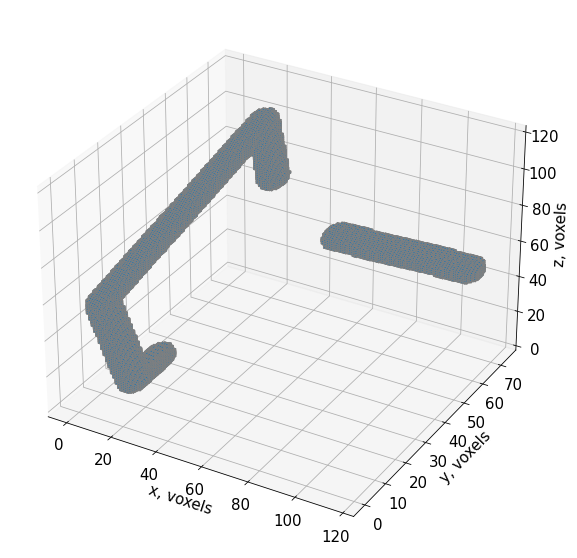

CPU times: user 48.8 s, sys: 947 ms, total: 49.8 s
Wall time: 48.5 s


In [55]:
%%time
#from holopy.scattering.scatterer import Indicators
#indi = Indicators(lambda x: sph_rule(x, R=0.5, delta=1))
#copa_sph = Scatterer(indi, n=1.5, center=(1,1,0))

from mpl_toolkits.mplot3d import Axes3D
def make_ax(grid=False):
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x, voxels")
    ax.set_ylabel("y, voxels")
    ax.set_zlabel("z, voxels")
    ax.grid(grid)
    return ax

filam = np.array(copa_fil.voxelate(spacing=0.002), dtype=bool)

#filled = np.zeros((filam[:,0].max()+1, filam[:,1].max()+1, filam[:,2].max()+1), dtype=bool)
#for c in filam:
#    filled[c[0],c[1],c[2]] = True

ax = make_ax(True)
ax.voxels(filam, edgecolors='gray', shade=False)
plt.savefig('cdr/adda_2fil_scheme.png')
plt.show()

In [56]:
import numpy as np
from holopy.scattering.theory.scatteringtheory import ScatteringTheory

class Backscattered(ScatteringTheory):
    def __init__(self, theory):
        self.theory = theory

    def can_handle(self, scatterer):
        return self.theory.can_handle(scatterer)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        r, theta, phi = pos
        theta_backscattered = np.pi - theta
        pos_backscattered = np.array([r, theta_backscattered, phi])

        args = (scatterer, pos_backscattered, medium_wavevec, medium_index)
        scat_matrices = np.array(self.theory.raw_scat_matrs(*args))

        # account for coordinate change in decomposition of incoming
        # light into theta, phi components:
        scat_matrices[:, 0, 0] *= -1
        scat_matrices[:, 0, 1] *= -1  # FIXME is it this or the transpose? NOW IT IS

        return scat_matrices

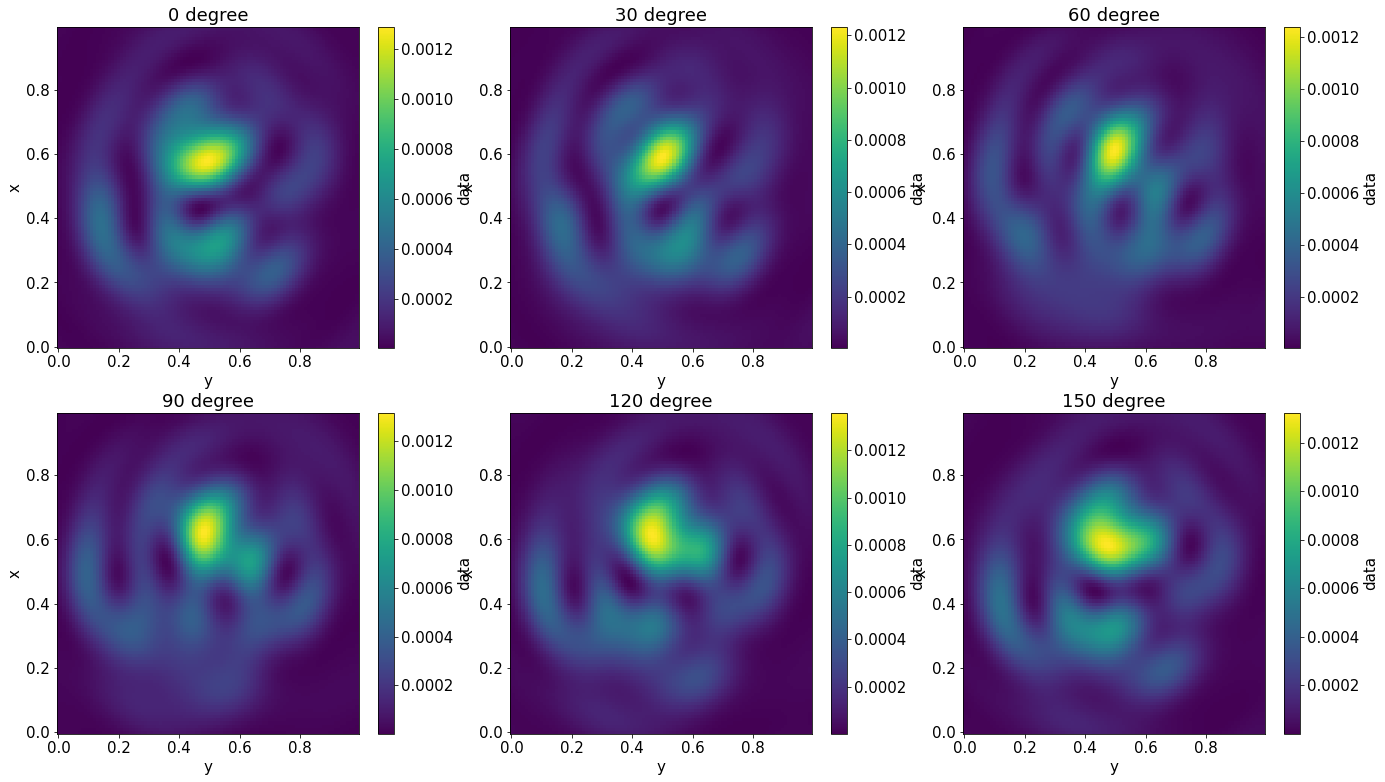

CPU times: user 22 s, sys: 1.59 s, total: 23.6 s
Wall time: 6min 13s


In [57]:
%%time
copa_fil = Scatterer(indi, n=0.0345+1j*2.859, center=(0.5,0.5,0))
detector = hp.detector_grid(100, .01)

holo_fil = {}
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, max_dpl_size=0.002)))
holo_unp = calc_unpolar(detector, copa_fil, medium_index=1.515, illum_wavelen=0.465, theory=len_dda)
for i,th in enumerate([0,30,60,90,120,150]):
    #th *= np.pi/180
    holo_fil[th] = apply_pol(holo_unp, th*np.pi/180)
    holo_fil[th].plot(ax=axes[i])
    axes[i].set_title(str(th)+' degree')
plt.show()

### Transposed

In [58]:
import numpy as np
from holopy.scattering.theory.scatteringtheory import ScatteringTheory

class Backscattered(ScatteringTheory):
    def __init__(self, theory):
        self.theory = theory

    def can_handle(self, scatterer):
        return self.theory.can_handle(scatterer)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        r, theta, phi = pos
        theta_backscattered = np.pi - theta
        pos_backscattered = np.array([r, theta_backscattered, phi])

        args = (scatterer, pos_backscattered, medium_wavevec, medium_index)
        scat_matrices = np.array(self.theory.raw_scat_matrs(*args))

        # account for coordinate change in decomposition of incoming
        # light into theta, phi components:
        scat_matrices[:, 0, 0] *= -1
        scat_matrices[:, 1, 0] *= -1  # FIXME is it this or the transpose? NOW IT IS

        return scat_matrices

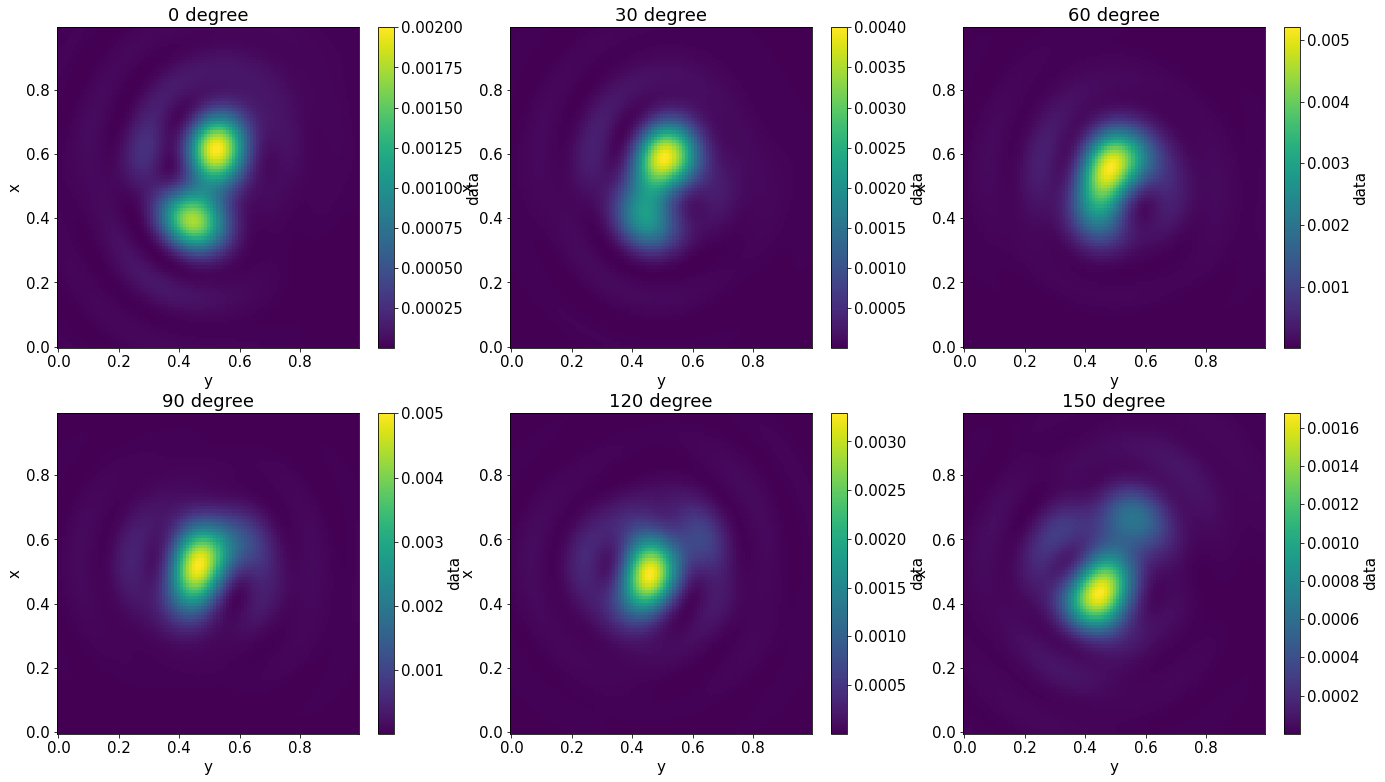

CPU times: user 21.8 s, sys: 1.59 s, total: 23.4 s
Wall time: 6min 14s


In [59]:
%%time
copa_fil = Scatterer(indi, n=0.0345+1j*2.859, center=(0.5,0.5,0))
detector = hp.detector_grid(100, .01)

holo_fil = {}
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, max_dpl_size=0.002)))
holo_unp = calc_unpolar(detector, copa_fil, medium_index=1.515, illum_wavelen=0.465, theory=len_dda)
for i,th in enumerate([0,30,60,90,120,150]):
    #th *= np.pi/180
    holo_fil[th] = apply_pol(holo_unp, th*np.pi/180)
    holo_fil[th].plot(ax=axes[i])
    axes[i].set_title(str(th)+' degree')
plt.show()

### Only (0,0)

In [60]:
import numpy as np
from holopy.scattering.theory.scatteringtheory import ScatteringTheory

class Backscattered(ScatteringTheory):
    def __init__(self, theory):
        self.theory = theory

    def can_handle(self, scatterer):
        return self.theory.can_handle(scatterer)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        r, theta, phi = pos
        theta_backscattered = np.pi - theta
        pos_backscattered = np.array([r, theta_backscattered, phi])

        args = (scatterer, pos_backscattered, medium_wavevec, medium_index)
        scat_matrices = np.array(self.theory.raw_scat_matrs(*args))

        # account for coordinate change in decomposition of incoming
        # light into theta, phi components:
        scat_matrices[:, 0, 0] *= -1
        #scat_matrices[:, 1, 0] *= -1  # FIXME is it this or the transpose? NOW IT IS

        return scat_matrices

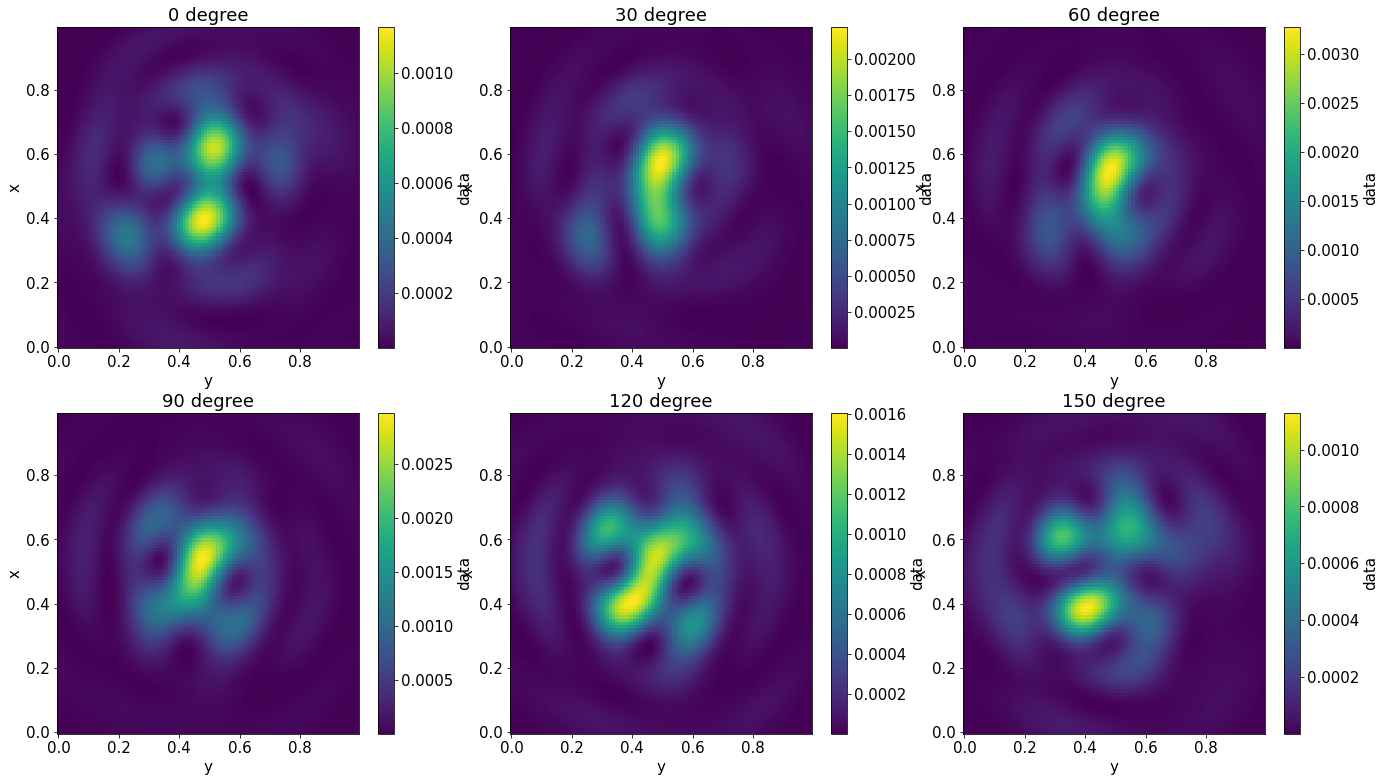

CPU times: user 21.8 s, sys: 1.48 s, total: 23.3 s
Wall time: 6min 14s


In [61]:
%%time
copa_fil = Scatterer(indi, n=0.0345+1j*2.859, center=(0.5,0.5,0))
detector = hp.detector_grid(100, .01)

holo_fil = {}
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, max_dpl_size=0.002)))
holo_unp = calc_unpolar(detector, copa_fil, medium_index=1.515, illum_wavelen=0.465, theory=len_dda)
for i,th in enumerate([0,30,60,90,120,150]):
    #th *= np.pi/180
    holo_fil[th] = apply_pol(holo_unp, th*np.pi/180)
    holo_fil[th].plot(ax=axes[i])
    axes[i].set_title(str(th)+' degree')
plt.show()

### Transposed, BIG pixels 30nm

In [62]:
import numpy as np
from holopy.scattering.theory.scatteringtheory import ScatteringTheory

class Backscattered(ScatteringTheory):
    def __init__(self, theory):
        self.theory = theory

    def can_handle(self, scatterer):
        return self.theory.can_handle(scatterer)

    def raw_scat_matrs(self, scatterer, pos, medium_wavevec, medium_index):
        r, theta, phi = pos
        theta_backscattered = np.pi - theta
        pos_backscattered = np.array([r, theta_backscattered, phi])

        args = (scatterer, pos_backscattered, medium_wavevec, medium_index)
        scat_matrices = np.array(self.theory.raw_scat_matrs(*args))

        # account for coordinate change in decomposition of incoming
        # light into theta, phi components:
        scat_matrices[:, 0, 0] *= -1
        scat_matrices[:, 1, 0] *= -1  # FIXME is it this or the transpose? NOW IT IS

        return scat_matrices

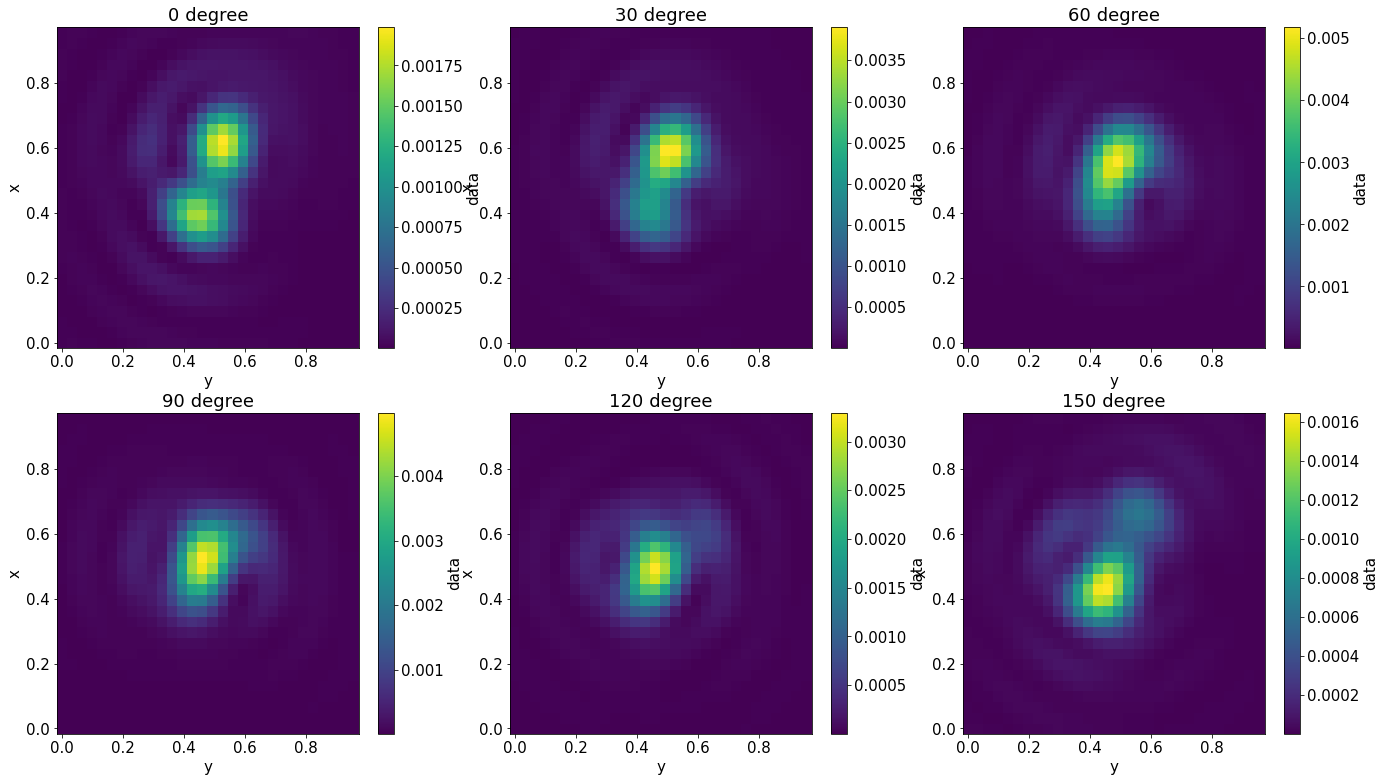

CPU times: user 5.77 s, sys: 944 ms, total: 6.71 s
Wall time: 6min 10s


In [63]:
%%time
copa_fil = Scatterer(indi, n=0.0345+1j*2.859, center=(0.5,0.5,0))
detector = hp.detector_grid(30, .033)

holo_fil = {}
fig, axes = plt.subplots(2, 3, figsize=(23, 13))
axes = np.ravel(axes)
len_dda = Lens(1.38, Backscattered(DDA(use_gpu=True, max_dpl_size=0.002)))
holo_unp = calc_unpolar(detector, copa_fil, medium_index=1.515, illum_wavelen=0.465, theory=len_dda)
for i,th in enumerate([0,30,60,90,120,150]):
    #th *= np.pi/180
    holo_fil[th] = apply_pol(holo_unp, th*np.pi/180)
    holo_fil[th].plot(ax=axes[i])
    axes[i].set_title(str(th)+' degree')
plt.show()